In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import statsmodels.tsa as ts
import statsmodels.graphics.tsaplots as tsplt
import pmdarima as pm
import datetime as dt
from datetime import datetime 
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
import yfinance as y
from pandas_datareader import data as pdr
y.pdr_override()
tf.config.run_functions_eagerly(True)
pd.set_option('display.max_columns', None)

## TimeSeries Forecasting (ARIMA/ARIMAX)

In [54]:
data =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Corn_CBOT_data.csv')
data = data[data["symbol"]=="ZCH19"]
data["tradingDay"]=pd.to_datetime(data["tradingDay"],format="%Y-%m-%d")
data=data.set_index("tradingDay")
data.head()

,symbol,timestamp,open,high,low,close,volume,openInterest
tradingDay,,,,,,,,
2016-12-14,ZCH19,2016-12-14T00:00:00-06:00,405.50,405.50,405.50,405.50,0,0
2016-12-15,ZCH19,2016-12-15T00:00:00-06:00,401.75,401.75,401.75,401.75,0,0
2016-12-16,ZCH19,2016-12-16T00:00:00-06:00,401.75,401.75,401.75,401.75,0,0
2016-12-19,ZCH19,2016-12-19T00:00:00-06:00,400.00,400.00,400.00,400.00,0,0
2016-12-20,ZCH19,2016-12-20T00:00:00-06:00,400.00,400.00,398.50,398.50,20,20


In [55]:
data["MA10"] = data["close"].shift(1).rolling(window=10).mean().fillna(0)
data["MA50"] = data["close"].shift(1).rolling(window=50).mean().fillna(0)
data["MA200"] = data["close"].shift(1).rolling(window=200).mean().fillna(0)
data["MACD"] = (data.close.ewm(span=12).mean().fillna(0)-data.close.ewm(span=26).mean().fillna(0))
data["MACD_Signal"]=data.MACD.ewm(span=9).mean().fillna(0)
data["MACD_Indicator"]=data["MACD"]-data["MACD_Signal"].fillna(0)
data["Bollinger_High"] = (data["close"].rolling(window=20).mean()+2*data["close"].rolling(window=20).std()).fillna(0)
data["Bollinger_Low"] = (data["close"].rolling(window=20).mean()-2*data["close"].rolling(window=20).std()).fillna(0)

(-5.0, 5.0)

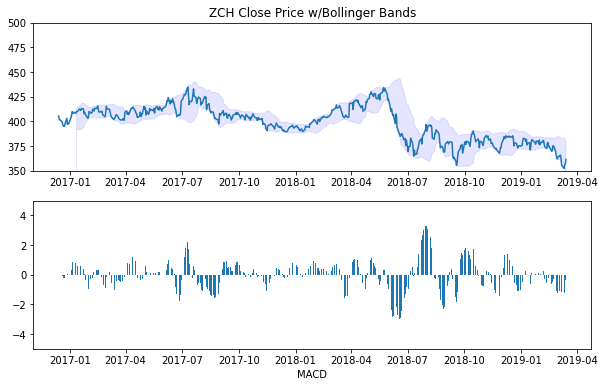

In [8]:
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(211)
ax1.plot(data["close"])
#ax1.xticks(data["tradingDay"])
ax1.fill_between(data.index,data["Bollinger_High"],data["Bollinger_Low"], color='b', alpha=.1)
ax1.set_title("ZCH Close Price w/Bollinger Bands")
ax1.set_ylim((350,500))
ax2=fig.add_subplot(212)
ax2.bar(x=data.index,height=data["MACD_Indicator"])
ax2.set_xlabel("MACD")
ax2.set_ylim((-5,5))

In [5]:
train=data["close"][0:-31]
test=data["close"][-31:]

In [6]:
ts.stattools.kpss(train)[1]

C:\Users\cnaka\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\cnaka\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


0.01

In [7]:
ts.stattools.adfuller(train)[1]

0.26424169943875486

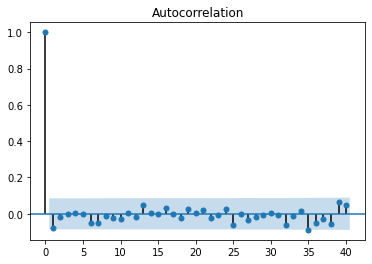

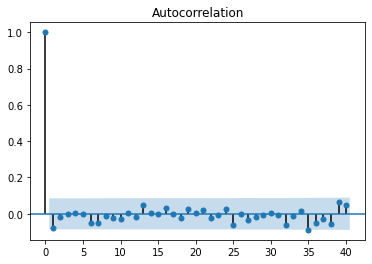

In [8]:
tsplt.plot_acf(train.diff()[1:], lags=40)

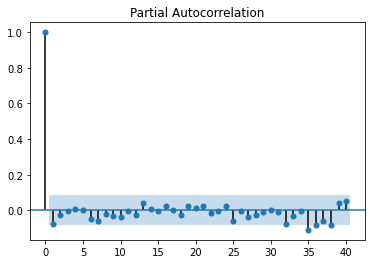

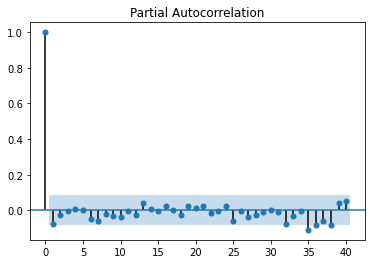

In [9]:
tsplt.plot_pacf(train.diff()[1:], lags=40)

In [10]:
arima=pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2833.337, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2832.989, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2831.673, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2831.522, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2831.115, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.572 seconds


In [11]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  534
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1414.558
Date:                Mon, 01 Feb 2021   AIC                           2831.115
Time:                        20:26:09   BIC                           2835.394
Sample:                             0   HQIC                          2832.790
                                - 534                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        11.8228      0.520     22.738      0.000      10.804      12.842
===================================================================================
Ljung-Box (Q):                       28.32   Jarque-Bera (JB):                80.54
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.18
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

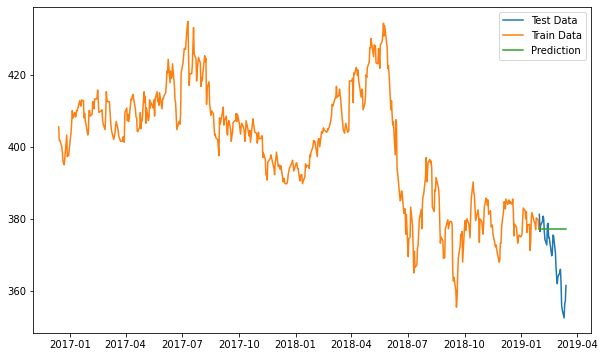

In [12]:
fig=plt.figure(figsize=(10,6))
ax=plt.axes()
ax.plot(data.index[-31:],test,label="Test Data")
ax.plot(data.index[0:-31],train,label="Train Data")
ax.plot(data.index[-31:],arima.predict(n_periods=31),label="Prediction")
ax.legend()

In [13]:
test

tradingDay
2019-01-30    381.25
2019-01-31    376.50
2019-02-01    378.25
2019-02-04    379.25
2019-02-05    380.75
2019-02-06    380.00
2019-02-07    376.50
2019-02-08    374.25
2019-02-11    372.75
2019-02-12    378.25
2019-02-13    378.75
2019-02-14    374.75
2019-02-15    374.75
2019-02-19    369.75
2019-02-20    370.75
2019-02-21    375.50
2019-02-22    375.25
2019-02-25    370.50
2019-02-26    366.25
2019-02-27    363.75
2019-02-28    362.00
2019-03-01    364.00
2019-03-04    365.00
2019-03-05    366.00
2019-03-06    362.50
2019-03-07    356.00
2019-03-08    354.75
2019-03-11    352.50
2019-03-12    356.50
2019-03-13    357.25
2019-03-14    361.50
Name: close, dtype: float64

In [42]:
prod = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\cmdty_production_forecast_data.csv')
prod=prod[prod["symbol"]=="ZCYAUS.CM"].sort_values(by="date")
prod["date"]=pd.to_datetime(prod["date"],format="%Y-%m-%d")

In [43]:
prod.head()

,id,symbol,date,value
82477,118217,ZCYAUS.CM,2014-06-02,157.15255
85519,121259,ZCYAUS.CM,2014-06-03,157.15255
88561,124301,ZCYAUS.CM,2014-06-04,157.15255
91603,127343,ZCYAUS.CM,2014-06-05,157.15255
94645,130385,ZCYAUS.CM,2014-06-06,157.15255


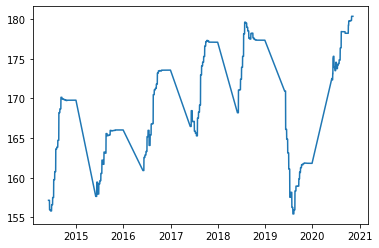

In [44]:
plt.plot(prod["date"],prod["value"])

In [28]:
data.merge(right=prod,how="left",left_on="tradingDay",right_on="date")

,symbol_x,timestamp,open,high,low,close,volume,openInterest,MA10,MA50,MA200,MACD,MACD_Signal,MACD_Indicator,Bollinger_High,Bollinger_Low,id,symbol_y,date,value
0,ZCH19,2016-12-14T00:00:00-06:00,405.50,405.50,405.50,405.50,0,0,0.000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2175785.0,ZCYAUS.CM,2016-12-14,173.57801
1,ZCH19,2016-12-15T00:00:00-06:00,401.75,401.75,401.75,401.75,0,0,0.000,0.000,0.00000,-0.084135,-0.046741,-0.037393,0.000000,0.000000,2178832.0,ZCYAUS.CM,2016-12-15,173.57801
2,ZCH19,2016-12-16T00:00:00-06:00,401.75,401.75,401.75,401.75,0,0,0.000,0.000,0.00000,-0.107204,-0.071521,-0.035683,0.000000,0.000000,2181879.0,ZCYAUS.CM,2016-12-16,173.57801
3,ZCH19,2016-12-19T00:00:00-06:00,400.00,400.00,400.00,400.00,0,0,0.000,0.000,0.00000,-0.178252,-0.107677,-0.070576,0.000000,0.000000,2191020.0,ZCYAUS.CM,2016-12-19,173.57801
4,ZCH19,2016-12-20T00:00:00-06:00,400.00,400.00,398.50,398.50,20,20,0.000,0.000,0.00000,-0.272795,-0.156796,-0.115999,0.000000,0.000000,2194067.0,ZCYAUS.CM,2016-12-20,173.57801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,ZCH19,2019-03-08T00:00:00-06:00,357.75,358.25,354.00,354.75,2265,1402,365.125,374.880,381.38125,-4.895846,-3.550240,-1.345607,382.714625,354.835375,NaN,NaN,NaT,NaN
561,ZCH19,2019-03-11T00:00:00-05:00,357.50,357.50,352.25,352.50,1747,1022,363.075,374.420,380.99875,-5.442936,-3.928779,-1.514157,383.140208,352.234792,NaN,NaN,NaT,NaN
562,ZCH19,2019-03-12T00:00:00-05:00,353.25,357.75,352.75,356.50,798,594,361.275,374.005,380.59000,-5.490451,-4.241113,-1.249338,382.904988,350.845012,NaN,NaN,NaT,NaN
563,ZCH19,2019-03-13T00:00:00-05:00,357.25,359.50,355.00,357.25,317,233,360.300,373.645,380.21875,-5.405280,-4.473947,-0.931333,381.464104,350.185896,NaN,NaN,NaT,NaN


In [41]:
pd.DatetimeIndex(prod["date"]).month.unique()

Int64Index([6, 7, 8, 9, 10, 11], dtype='int64', name='date')

In [51]:
wasde=pd.read_csv(r"C:\Users\cnaka\Class Notes\Capstone\Corn WASDE Rolling Forecast Data.csv")
wasde["date"]=pd.to_datetime(wasde["date"],format="%Y-%m-%d")
wasde.head()

,id,date,value,series_id
0,35499649,2006-08-10,72.09,141529
1,35499650,2006-09-11,71.84,141529
2,35499652,2006-10-10,71.05,141529
3,35499653,2006-11-10,71.05,141529
4,35499654,2006-12-11,71.05,141529


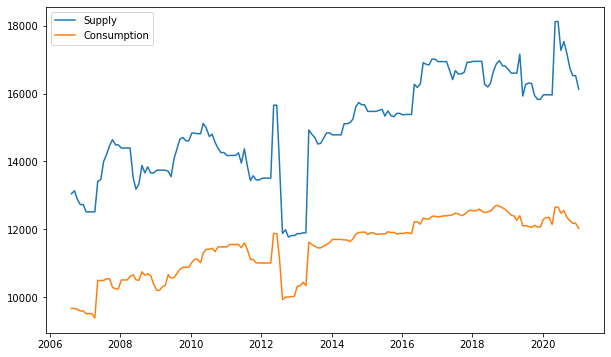

In [58]:
fig=plt.figure(figsize=(10,6))
ax=plt.axes()
ax.plot(wasde[wasde["series_id"]==141539]["date"],wasde[wasde["series_id"]==141539]["value"],label="Supply")
ax.plot(wasde[wasde["series_id"]==141531]["date"],wasde[wasde["series_id"]==141531]["value"],label="Consumption")
ax.legend()

# Neural Nets

In [24]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
tf.config.run_functions_eagerly(True)

In [13]:
data.head()

,symbol,timestamp,open,high,low,close,volume,openInterest,MA10,MA50,MA200,MACD,MACD_Signal,MACD_Indicator,Bollinger_High,Bollinger_Low
tradingDay,,,,,,,,,,,,,,,,
2016-12-14,ZCH19,2016-12-14T00:00:00-06:00,405.50,405.50,405.50,405.50,0,0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2016-12-15,ZCH19,2016-12-15T00:00:00-06:00,401.75,401.75,401.75,401.75,0,0,0.0,0.0,0.0,-0.084135,-0.046741,-0.037393,0.0,0.0
2016-12-16,ZCH19,2016-12-16T00:00:00-06:00,401.75,401.75,401.75,401.75,0,0,0.0,0.0,0.0,-0.107204,-0.071521,-0.035683,0.0,0.0
2016-12-19,ZCH19,2016-12-19T00:00:00-06:00,400.00,400.00,400.00,400.00,0,0,0.0,0.0,0.0,-0.178252,-0.107677,-0.070576,0.0,0.0
2016-12-20,ZCH19,2016-12-20T00:00:00-06:00,400.00,400.00,398.50,398.50,20,20,0.0,0.0,0.0,-0.272795,-0.156796,-0.115999,0.0,0.0


In [24]:
(data.index[-1]-data.index[0]).days

820

In [27]:

train=data.loc[data.index[0]:data.index[round(len(data)*.6)]][["close"#,"volume","MACD_Indicator","Open","High","Low","Volume","CenMA10"#,"Close_VIX","Volume","MA10","MA50","MA200","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]
validate=data.loc[data.index[round(len(data)*.6)+1]:data.index[round(len(data)*.8)]][["close"#,"volume","MACD_Indicator","Open","High","Low","Volume","CenMA10"#,"Close_VIX","Volume","MA10","MA50","MA200","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]
test=data.loc[data.index[round(len(data)*.8)+1]:data.index[-1]][["close"#,"volume","MACD_Indicator","Open","High","Low","Volume","CenMA10"#,"Close_VIX","Volume","MA10","MA50","MA200","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled=scaler.fit_transform(train)
validate_scaled=scaler.transform(validate)
test_scaled=scaler.transform(test)

In [10]:
def create_datasets(X,w,h,l=0):
    X_set,Y_set=[],[]
    for i in range(w,len(X)):
        X_set.append(X[i-w:i,])
        Y_set.append(X[i:i+h,l]#.reshape((w,1))
                    )
    return np.array(X_set),np.array(Y_set)

In [32]:
X_train,Y_train=create_datasets(train_scaled,10,1)
X_validate,Y_validate=create_datasets(validate_scaled,10,1)
X_test,Y_test=create_datasets(test_scaled,10,1)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(330, 10, 1) (330, 1)
(103, 10, 1) (103, 1)
(102, 10, 1) (102, 1)


In [36]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])
model.compile(loss="MeanSquaredError",optimizer = "adam")
model.fit(x=X_train,y=Y_train,epochs=100,validation_data=(X_test,Y_test))

Epoch 1/100
11/11 [==============================] - 1s 48ms/step - loss: 0.8924 - val_loss: 9.2730
Epoch 2/100
11/11 [==============================] - 0s 41ms/step - loss: 0.5856 - val_loss: 5.3827
Epoch 3/100
11/11 [==============================] - 1s 46ms/step - loss: 0.4424 - val_loss: 3.4614
Epoch 4/100
11/11 [==============================] - 0s 42ms/step - loss: 0.4222 - val_loss: 3.9300
Epoch 5/100
11/11 [==============================] - 0s 41ms/step - loss: 0.4029 - val_loss: 3.3648
Epoch 6/100
11/11 [==============================] - 0s 41ms/step - loss: 0.3891 - val_loss: 3.0403
Epoch 7/100
11/11 [==============================] - 0s 39ms/step - loss: 0.3776 - val_loss: 3.1910
Epoch 8/100
11/11 [==============================] - 0s 43ms/step - loss: 0.3598 - val_loss: 3.0703
Epoch 9/100
11/11 [==============================] - 0s 41ms/step - loss: 0.3368 - val_loss: 2.8049
Epoch 10/100
11/11 [==============================] - 1s 47ms/step - loss: 0.3219 - val_loss: 2.6136

In [35]:
model.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 13ms/step - loss: 2.1411


2.1411075592041016

## Include technical indicators

In [38]:

train=data.loc[data.index[0]:data.index[round(len(data)*.6)]][["close","volume","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]
validate=data.loc[data.index[round(len(data)*.6)+1]:data.index[round(len(data)*.8)]][["close","volume","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]
test=data.loc[data.index[round(len(data)*.8)+1]:data.index[-1]][["close","volume","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]
scaler = StandardScaler()
train_scaled=scaler.fit_transform(train)
validate_scaled=scaler.transform(validate)
test_scaled=scaler.transform(test)
X_train,Y_train=create_datasets(train_scaled,10,1)
X_validate,Y_validate=create_datasets(validate_scaled,10,1)
X_test,Y_test=create_datasets(test_scaled,10,1)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(330, 10, 5) (330, 1)
(103, 10, 5) (103, 1)
(102, 10, 5) (102, 1)


In [39]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])
model.compile(loss="MeanSquaredError",optimizer = "adam")
model.fit(x=X_train,y=Y_train,epochs=100,validation_data=(X_test,Y_test))

Epoch 1/100
 1/11 [=>............................] - ETA: 0s - loss: 1.0126

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


11/11 [==============================] - 1s 93ms/step - loss: 0.8148 - val_loss: 12.1482
Epoch 2/100
11/11 [==============================] - 1s 91ms/step - loss: 0.4811 - val_loss: 10.9595
Epoch 3/100
11/11 [==============================] - 1s 91ms/step - loss: 0.3890 - val_loss: 11.4152
Epoch 4/100
11/11 [==============================] - 1s 110ms/step - loss: 0.3537 - val_loss: 12.4296
Epoch 5/100
11/11 [==============================] - 1s 97ms/step - loss: 0.3467 - val_loss: 12.5216
Epoch 6/100
11/11 [==============================] - 1s 98ms/step - loss: 0.3366 - val_loss: 12.4819
Epoch 7/100
11/11 [==============================] - 1s 89ms/step - loss: 0.3221 - val_loss: 12.5861
Epoch 8/100
11/11 [==============================] - 1s 89ms/step - loss: 0.3143 - val_loss: 12.7088
Epoch 9/100
11/11 [==============================] - 1s 102ms/step - loss: 0.3135 - val_loss: 13.1186
Epoch 10/100
11/11 [==============================] - 1s 92ms/step - loss: 0.2889 - val_loss: 13.2836

# Spot Price+Premium

In [2]:
data =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Corn_CBOT_data.csv')
data["tradingDay"]=pd.to_datetime(data["tradingDay"],format="%Y-%m-%d")
data.head()

,symbol,timestamp,tradingDay,open,high,low,close,volume,openInterest
0,ZCH00,2000-01-03T00:00:00-06:00,2000-01-03,204.50,205.75,200.50,200.75,0,0
1,ZCH00,2000-01-04T00:00:00-06:00,2000-01-04,200.75,203.50,200.75,203.00,0,0
2,ZCH00,2000-01-05T00:00:00-06:00,2000-01-05,202.50,203.25,201.00,203.00,0,0
3,ZCH00,2000-01-06T00:00:00-06:00,2000-01-06,203.00,205.75,203.00,203.75,0,0
4,ZCH00,2000-01-07T00:00:00-06:00,2000-01-07,203.25,207.75,202.50,207.00,0,0


In [3]:
spot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_CORN_cash_price.csv')
spot["tradingDay"]=pd.to_datetime(spot["tradingDay"],format="%Y-%m-%d")
spot=spot.set_index("tradingDay")
spot.head()

,symbol,timestamp,open,high,low,close,volume,openInterest
tradingDay,,,,,,,,
2000-01-03,ZCY00,2000-01-03T00:00:00-06:00,200.75,200.75,200.75,200.75,0,0
2000-01-04,ZCY00,2000-01-04T00:00:00-06:00,203.00,203.00,203.00,203.00,0,0
2000-01-05,ZCY00,2000-01-05T00:00:00-06:00,203.00,203.00,203.00,203.00,0,0
2000-01-06,ZCY00,2000-01-06T00:00:00-06:00,202.75,202.75,202.75,202.75,0,0
2000-01-07,ZCY00,2000-01-07T00:00:00-06:00,206.00,206.00,206.00,206.00,0,0


In [4]:
data=data.merge(spot["close"],on="tradingDay")
data=data.rename(columns={"close_y":"spot_price","close_x":"close"})
data.head()

,symbol,timestamp,tradingDay,open,high,low,close,volume,openInterest,spot_price
0,ZCH00,2000-01-03T00:00:00-06:00,2000-01-03,204.50,205.75,200.50,200.75,0,0,200.75
1,ZCH01,2000-01-03T00:00:00-06:00,2000-01-03,242.75,242.75,239.75,239.75,0,0,200.75
2,ZCK00,2000-01-03T00:00:00-06:00,2000-01-03,211.25,212.25,207.75,208.00,0,0,200.75
3,ZCN00,2000-01-03T00:00:00-06:00,2000-01-03,217.75,219.00,214.50,214.75,0,0,200.75
4,ZCN01,2000-01-03T00:00:00-06:00,2000-01-03,252.00,252.00,248.75,248.75,0,0,200.75


In [5]:
data["expiration_date"]=[pd.to_datetime("1900-12-31",format = "%Y-%m-%d")]*len(data)
for i in range(len(data)):
    quarter='01-31'
    if (data["symbol"][i][2]=='H'):
        quarter='03-31'
    elif (data["symbol"][i][2]=='K'):
        quarter='05-31'
    elif (data["symbol"][i][2]=='N'):
        quarter='07-31'
    elif (data["symbol"][i][2]=='U'):
        quarter='09-30'
    elif (data["symbol"][i][2]=='Z'):
        quarter='12-31'
    year = '20'+data["symbol"][i][3:]
    data.iloc[i,10]=pd.to_datetime(year+'-'+quarter,format = "%Y-%m-%d")

In [6]:
data.head()

,symbol,timestamp,tradingDay,open,high,low,close,volume,openInterest,spot_price,expiration_date
0,ZCH00,2000-01-03T00:00:00-06:00,2000-01-03,204.50,205.75,200.50,200.75,0,0,200.75,2000-03-31
1,ZCH01,2000-01-03T00:00:00-06:00,2000-01-03,242.75,242.75,239.75,239.75,0,0,200.75,2001-03-31
2,ZCK00,2000-01-03T00:00:00-06:00,2000-01-03,211.25,212.25,207.75,208.00,0,0,200.75,2000-05-31
3,ZCN00,2000-01-03T00:00:00-06:00,2000-01-03,217.75,219.00,214.50,214.75,0,0,200.75,2000-07-31
4,ZCN01,2000-01-03T00:00:00-06:00,2000-01-03,252.00,252.00,248.75,248.75,0,0,200.75,2001-07-31


In [7]:
data["risk_premium"]=data["close"]-data["spot_price"]
data["days_until_maturity"]=data["tradingDay"]-data["expiration_date"]
data.head()

,symbol,timestamp,tradingDay,open,high,low,close,volume,openInterest,spot_price,expiration_date,risk_premium,days_until_maturity
0,ZCH00,2000-01-03T00:00:00-06:00,2000-01-03,204.50,205.75,200.50,200.75,0,0,200.75,2000-03-31,0.00,-88 days
1,ZCH01,2000-01-03T00:00:00-06:00,2000-01-03,242.75,242.75,239.75,239.75,0,0,200.75,2001-03-31,39.00,-453 days
2,ZCK00,2000-01-03T00:00:00-06:00,2000-01-03,211.25,212.25,207.75,208.00,0,0,200.75,2000-05-31,7.25,-149 days
3,ZCN00,2000-01-03T00:00:00-06:00,2000-01-03,217.75,219.00,214.50,214.75,0,0,200.75,2000-07-31,14.00,-210 days
4,ZCN01,2000-01-03T00:00:00-06:00,2000-01-03,252.00,252.00,248.75,248.75,0,0,200.75,2001-07-31,48.00,-575 days


In [8]:
premiums = data.pivot(index="days_until_maturity",columns="symbol",values="risk_premium")
premiums.tail()

symbol,ZCH00,ZCH01,ZCH02,ZCH03,ZCH04,ZCH05,ZCH06,ZCH07,ZCH08,ZCH09,ZCH10,ZCH11,ZCH12,ZCH13,ZCH14,ZCH15,ZCH16,ZCH17,ZCH18,ZCH19,ZCH20,ZCH21,ZCH22,ZCK00,ZCK01,ZCK02,ZCK03,ZCK04,ZCK05,ZCK06,ZCK07,ZCK08,ZCK09,ZCK10,ZCK11,ZCK12,ZCK13,ZCK14,ZCK15,ZCK16,ZCK17,ZCK18,ZCK19,ZCK20,ZCK21,ZCK22,ZCN00,ZCN01,ZCN02,ZCN03,ZCN04,ZCN05,ZCN06,ZCN07,ZCN08,ZCN09,ZCN10,ZCN11,ZCN12,ZCN13,ZCN14,ZCN15,ZCN16,ZCN17,ZCN18,ZCN19,ZCN20,ZCN21,ZCN22,ZCN23,ZCU00,ZCU01,ZCU02,ZCU03,ZCU04,ZCU05,ZCU06,ZCU07,ZCU08,ZCU09,ZCU10,ZCU11,ZCU12,ZCU13,ZCU14,ZCU15,ZCU16,ZCU17,ZCU18,ZCU19,ZCU20,ZCU21,ZCU22,ZCZ00,ZCZ01,ZCZ02,ZCZ03,ZCZ04,ZCZ05,ZCZ06,ZCZ07,ZCZ08,ZCZ09,ZCZ10,ZCZ11,ZCZ12,ZCZ13,ZCZ14,ZCZ15,ZCZ16,ZCZ17,ZCZ18,ZCZ19,ZCZ20,ZCZ21,ZCZ22,ZCZ23
days_until_maturity,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-20 days,NaN,NaN,-9.50,-8.50,-4.00,-3.25,NaN,NaN,18.50,-14.5,-2.75,13.0,NaN,-6.75,2.75,-5.00,-3.5,NaN,NaN,-1.50,-5.25,NaN,NaN,-2.00,-4.25,NaN,NaN,-5.25,-11.75,0.75,-13.25,NaN,-6.75,-3.25,-2.50,-17.0,NaN,NaN,-8.75,-4.00,-3.75,0.75,NaN,6.50,NaN,NaN,3.25,-0.5,-3.75,-4.25,NaN,-5.50,-2.25,0.00,24.00,NaN,NaN,5.50,6.75,13.5,15.50,NaN,-6.50,6.50,-3.25,-25.00,NaN,NaN,NaN,NaN,NaN,-10.50,-12.25,-12.25,-20.50,NaN,NaN,3.75,0.75,-35.75,11.75,NaN,-42.25,-35.75,-32.00,-20.0,NaN,NaN,0.75,-26.00,-12.75,NaN,NaN,-5.0,-4.00,-5.75,-1.00,NaN,NaN,1.75,-15.50,5.5,17.75,NaN,NaN,-11.75,-6.5,4.50,-7.75,NaN,4.00,-0.25,-21.00,NaN,NaN,NaN,NaN
-19 days,NaN,-1.75,-4.75,-7.50,-3.75,NaN,NaN,-0.50,16.50,-14.5,-4.25,NaN,-10.00,-3.25,3.75,-4.25,NaN,NaN,0.50,-1.25,-2.50,NaN,NaN,-4.75,NaN,NaN,-9.50,-6.00,-11.00,0.00,NaN,-1.25,-7.00,-2.50,5.75,NaN,NaN,-3.50,-13.00,-4.25,-4.25,NaN,NaN,8.00,NaN,NaN,1.25,-0.5,-4.25,NaN,-10.5,-6.50,-1.00,0.50,NaN,NaN,-2.5,-12.00,0.00,13.5,NaN,NaN,-5.50,6.75,-3.75,-33.25,NaN,NaN,NaN,NaN,8.75,NaN,-11.50,-10.50,NaN,NaN,3.25,-1.75,-1.00,-35.25,NaN,NaN,-41.00,-31.25,-34.25,-20.0,NaN,5.5,1.00,-24.75,-5.50,NaN,NaN,-6.5,-0.25,-6.25,-0.75,NaN,-6.50,3.25,-14.50,5.0,NaN,NaN,-8.50,-12.50,-4.5,-0.25,NaN,3.50,0.50,0.50,-18.25,NaN,NaN,NaN,NaN
-18 days,-0.25,-1.25,-3.75,-9.75,NaN,NaN,8.75,-0.75,20.25,-13.5,NaN,NaN,-5.00,1.00,7.75,-5.50,NaN,0.5,0.75,-3.25,-1.50,NaN,NaN,NaN,NaN,-6.25,-10.00,-9.50,-11.75,NaN,NaN,0.25,-6.00,-2.50,-1.00,NaN,4.50,-1.50,-15.25,-9.25,NaN,NaN,-6.50,8.50,NaN,NaN,1.75,7.5,NaN,NaN,-10.0,-7.50,-1.75,-5.25,NaN,4.25,-2.5,-5.00,-24.75,NaN,NaN,-0.25,0.75,7.25,-5.50,NaN,-2.25,NaN,NaN,NaN,8.50,NaN,-9.00,-6.00,NaN,3.00,1.75,13.50,-5.75,NaN,NaN,-1.25,-38.50,-25.75,-24.50,NaN,-0.75,6.0,0.00,-25.75,NaN,NaN,NaN,-7.0,0.25,-6.50,NaN,-10.0,-6.25,2.25,-14.25,NaN,NaN,-6.25,-16.00,-30.00,-5.0,NaN,NaN,2.75,2.25,1.75,-22.25,NaN,NaN,NaN,NaN
-17 days,-2.25,1.75,-3.75,-13.00,NaN,-2.50,9.00,-8.25,13.25,NaN,NaN,16.0,-6.25,-13.75,-5.25,NaN,-7.5,-1.5,1.75,-2.75,NaN,NaN,NaN,NaN,-3.25,-7.50,-5.25,-10.75,NaN,NaN,-10.25,3.50,-5.75,-2.25,NaN,-15.0,0.25,-2.75,-16.00,NaN,NaN,0.00,-5.75,9.25,NaN,NaN,-2.75,NaN,NaN,-6.00,-11.5,-5.25,-1.25,NaN,28.25,-15.50,0.0,-19.25,NaN,NaN,2.75,0.25,0.50,5.00,NaN,NaN,-1.25,NaN,NaN,NaN,9.00,-6.50,-9.75,NaN,-19.25,4.50,-5.75,-1.00,NaN,NaN,4.75,-3.75,-22.00,-40.00,NaN,NaN,-0.25,7.0,-3.25,-26.25,NaN,NaN,NaN,-5.0,-0.25,NaN,NaN,-9.0,-6.00,5.00,-16.25,NaN,16.50,-5.75,-10.75,-30.00,NaN,NaN,-2.75,-4.25,2.25,2.50,NaN,NaN,NaN,NaN,NaN
-16 days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.50,-5.25,NaN,NaN,-20.50,3.25,-6.25,4.75,NaN,-42.75,2.00,-1.25,-29.50,NaN,NaN,-25.0,1.00,7.5,-2.25,NaN,-14.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


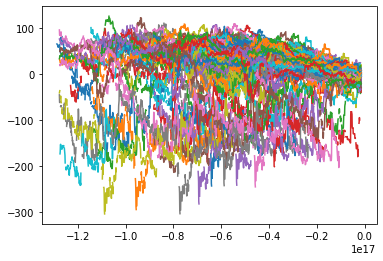

In [19]:
plt.plot(premiums)

In [11]:

train=spot.loc[spot.index[0]:spot.index[round(len(spot)*.6)]][["close"
                                               ]]
validate=spot.loc[spot.index[round(len(spot)*.6)+1]:spot.index[round(len(spot)*.8)]][["close"
                                               ]]
test=spot.loc[spot.index[round(len(spot)*.8)+1]:spot.index[-1]][["close"
                                               ]]
scaler = StandardScaler()
train_scaled=scaler.fit_transform(train)
validate_scaled=scaler.transform(validate)
test_scaled=scaler.transform(test)
X_train,Y_train=create_datasets(train_scaled,10,1)
X_validate,Y_validate=create_datasets(validate_scaled,10,1)
X_test,Y_test=create_datasets(test_scaled,10,1)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(3140, 10, 1) (3140, 1)
(1039, 10, 1) (1039, 1)
(1039, 10, 1) (1039, 1)


In [12]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])
model.compile(loss="MeanSquaredError",optimizer = "adam")
model.fit(x=X_train,y=Y_train,epochs=100,validation_data=(X_test,Y_test))

C:\Users\cnaka\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/100
99/99 [==============================] - 12s 120ms/step - loss: 0.4131 - val_loss: 0.0092
Epoch 2/100
99/99 [==============================] - 12s 120ms/step - loss: 0.0219 - val_loss: 0.0074
Epoch 3/100
99/99 [==============================] - 11s 115ms/step - loss: 0.0204 - val_loss: 0.0054
Epoch 4/100
99/99 [==============================] - 11s 116ms/step - loss: 0.0165 - val_loss: 0.0046
Epoch 5/100
99/99 [==============================] - 11s 116ms/step - loss: 0.0165 - val_loss: 0.0046
Epoch 6/100
99/99 [==============================] - 12s 119ms/step - loss: 0.0161 - val_loss: 0.0050
Epoch 7/100
99/99 [==============================] - 12s 116ms/step - loss: 0.0156 - val_loss: 0.0042
Epoch 8/100
99/99 [==============================] - 13s 133ms/step - loss: 0.0149 - val_loss: 0.0047
Epoch 9/100
99/99 [==============================] - 12s 119ms/step - loss: 0.0142 - val_loss: 0.0040
Epoch 10/100
99/99 [==============================] - 11s 116ms/step - loss: 0.013

In [13]:
model.evaluate(X_test,Y_test)

33/33 [==============================] - 2s 51ms/step - loss: 0.0012


0.0012180287158116698

In [20]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)

C:\Users\cnaka\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


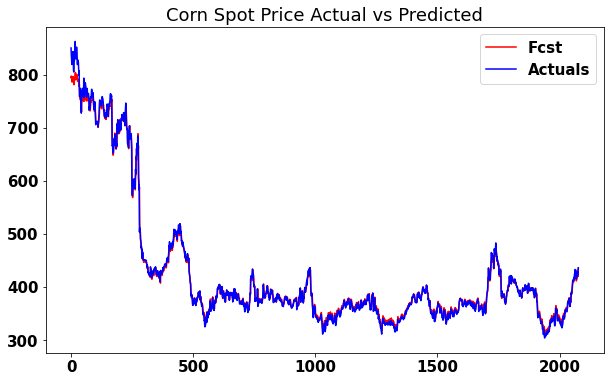

In [21]:
plt.figure(figsize=(10,6))
plt.plot(np.vstack((np.sqrt(scaler.var_[0])*model.predict(X_validate)+scaler.mean_[0],np.sqrt(scaler.var_[0])*model.predict(X_test)+scaler.mean_[0])),color="red",label="Fcst")
plt.plot(np.vstack((np.sqrt(scaler.var_[0])*Y_validate+scaler.mean_[0],np.sqrt(scaler.var_[0])*Y_test+scaler.mean_[0])),color="blue",label="Actuals")
plt.title("Corn Spot Price Actual vs Predicted")
plt.legend()

In [112]:
df=pd.DataFrame()
df["Forecast"]=(np.sqrt(scaler.var_[0])*model.predict(X_test).T+scaler.mean_[0]).flatten()
df["Actual"]=(np.sqrt(scaler.var_[0])*Y_test.T+scaler.mean_[0]).flatten()
df

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


,Forecast,Actual
0,318.366669,318.25
1,319.917603,315.75
2,318.830536,315.75
3,318.664368,324.75
4,326.355255,334.50
...,...,...
1034,420.265289,427.75
1035,424.075745,422.75
1036,419.066467,422.50
1037,417.808685,436.00


In [115]:
df["Predicted Move"]=np.zeros(len(df))
df["Correct Sign"]=np.zeros(len(df))
for i in range(1,len(df["Forecast"])):
    df.iloc[i,2]=(np.sign(df["Forecast"][i]-df["Actual"][i-1])==1)
    if np.sign(df["Forecast"][i]-df["Actual"][i-1])==np.sign(df["Actual"][i]-df["Actual"][i-1]):
        df.iloc[i,3]=1
print("DPA={}".format(round(sum(df["Correct Sign"])/len(df["Correct Sign"]),2)))

DPA=0.51


## Spot Price Classifier

In [47]:
spot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_CORN_cash_price.csv')
spot["tradingDay"]=pd.to_datetime(spot["tradingDay"],format="%Y-%m-%d")
spot=spot.set_index("tradingDay")
spot.head()

,symbol,timestamp,open,high,low,close,volume,openInterest
tradingDay,,,,,,,,
2000-01-03,ZCY00,2000-01-03T00:00:00-06:00,200.75,200.75,200.75,200.75,0,0
2000-01-04,ZCY00,2000-01-04T00:00:00-06:00,203.00,203.00,203.00,203.00,0,0
2000-01-05,ZCY00,2000-01-05T00:00:00-06:00,203.00,203.00,203.00,203.00,0,0
2000-01-06,ZCY00,2000-01-06T00:00:00-06:00,202.75,202.75,202.75,202.75,0,0
2000-01-07,ZCY00,2000-01-07T00:00:00-06:00,206.00,206.00,206.00,206.00,0,0


In [48]:
spot["direction"] = np.zeros(len(spot))


In [49]:
for i in range(1,len(spot)):
    if spot.iloc[i-1,5]>spot.iloc[i,5]:
        spot.iloc[i,8]=0
    elif spot.iloc[i-1,5]<spot.iloc[i,5]:
        spot.iloc[i,8]=1
    else:
        spot.iloc[i,8]=2

In [50]:
spot=spot[1:]

In [33]:
#spot["open"]=(spot["open"]-spot["open"].mean())/spot["open"].std()
#spot["high"]=(spot["high"]-spot["high"].mean())/spot["high"].std()
#spot["low"]=(spot["low"]-spot["low"].mean())/spot["low"].std()
spot["close"]=(spot["close"]-spot["close"].mean())/spot["close"].std()
spot.head()

,symbol,timestamp,open,high,low,close,volume,openInterest,direction
tradingDay,,,,,,,,,
2000-01-04,ZCY00,2000-01-04T00:00:00-06:00,-1.128509,-1.128509,-1.128509,-1.128509,0,0,1.0
2000-01-05,ZCY00,2000-01-05T00:00:00-06:00,-1.128509,-1.128509,-1.128509,-1.128509,0,0,2.0
2000-01-06,ZCY00,2000-01-06T00:00:00-06:00,-1.130120,-1.130120,-1.130120,-1.130120,0,0,0.0
2000-01-07,ZCY00,2000-01-07T00:00:00-06:00,-1.109179,-1.109179,-1.109179,-1.109179,0,0,1.0
2000-01-10,ZCY00,2000-01-10T00:00:00-06:00,-1.099514,-1.099514,-1.099514,-1.099514,0,0,1.0


In [52]:

train=np.array(spot.loc[spot.index[0]:spot.index[round(len(spot)*.6)]][["direction","close"
                                               ]])
validate=np.array(spot.loc[spot.index[round(len(spot)*.6)+1]:spot.index[round(len(spot)*.8)]][["direction","close"
                                               ]])
test=np.array(spot.loc[spot.index[round(len(spot)*.8)+1]:spot.index[-1]][["direction","close"
                                               ]])

X_train,Y_train=create_datasets(train,10,1)
X_validate,Y_validate=create_datasets(validate,10,1)
X_test,Y_test=create_datasets(test,10,1)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(3139, 10, 2) (3139, 1)
(1040, 10, 2) (1040, 1)
(1038, 10, 2) (1038, 1)


In [56]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]],activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.LSTM(20,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dense(3,activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy",optimizer = "adam")
model.fit(x=X_train,y=Y_train,epochs=10,validation_data=(X_test,Y_test))

Epoch 1/10
99/99 [==============================] - 7s 67ms/step - loss: 0.9047 - val_loss: 0.8308
Epoch 2/10
99/99 [==============================] - 7s 68ms/step - loss: 0.8652 - val_loss: 0.8210
Epoch 3/10
99/99 [==============================] - 6s 59ms/step - loss: 0.8622 - val_loss: 0.8246
Epoch 4/10
99/99 [==============================] - 6s 64ms/step - loss: 0.8604 - val_loss: 0.8346
Epoch 5/10
99/99 [==============================] - 6s 63ms/step - loss: 0.8562 - val_loss: 0.8228
Epoch 6/10
99/99 [==============================] - 6s 63ms/step - loss: 0.8556 - val_loss: 0.8308
Epoch 7/10
99/99 [==============================] - 7s 68ms/step - loss: 0.8579 - val_loss: 0.8228
Epoch 8/10
99/99 [==============================] - 6s 63ms/step - loss: 0.8568 - val_loss: 0.8221
Epoch 9/10
99/99 [==============================] - 6s 65ms/step - loss: 0.8529 - val_loss: 0.8220
Epoch 10/10
99/99 [==============================] - 6s 62ms/step - loss: 0.8546 - val_loss: 0.8216


In [45]:
import yfinance as y
from pandas_datareader import data as pdr
y.pdr_override()

In [52]:
oil=pdr.get_data_yahoo("USO", start="2000-01-01", end="2021-02-23")
usd=pdr.get_data_yahoo("DX-Y.NYB", start="2000-01-01", end="2021-02-23")
oil=oil["Close"]
usd=usd["Close"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [53]:
spot=spot.merge(oil,left_index=True,right_on="Date").rename(columns={"Close":"Oil"}).merge(usd,left_index=True,right_on="Date").rename(columns={"Close":"USD"})

In [54]:
ethanol=pd.read_csv('ethanol_demand.csv')
ethanol['Week_End']=pd.to_datetime(ethanol['Week_End'],format="%m/%d/%Y")
ethanol['BBL_Day']=pd.to_numeric(ethanol['BBL_Day'])
ethanol.head()

,Week_End,BBL_Day,Gal_Day
0,2014-01-03,756,"31,752"
1,2014-01-10,797,"33,474"
2,2014-01-17,802,"33,684"
3,2014-01-24,815,"34,230"
4,2014-01-31,801,"33,642"


In [55]:
spot=spot.merge(ethanol,left_index=True,right_on="Week_End")
spot.head()

,symbol,timestamp,open,high,low,close,volume,openInterest,direction,Oil,USD,Week_End,BBL_Day,Gal_Day
0,ZCY00,2014-01-03T00:00:00-06:00,424.00,424.00,424.00,424.00,0,0,1.0,270.000000,80.790001,2014-01-03,756,"31,752"
1,ZCY00,2014-01-10T00:00:00-06:00,430.25,430.25,430.25,430.25,0,0,1.0,265.519989,80.660004,2014-01-10,797,"33,474"
2,ZCY00,2014-01-17T00:00:00-06:00,424.00,424.00,424.00,424.00,0,0,0.0,269.519989,81.260002,2014-01-17,802,"33,684"
3,ZCY00,2014-01-24T00:00:00-06:00,429.50,429.50,429.50,429.50,0,0,1.0,276.640015,80.459999,2014-01-24,815,"34,230"
4,ZCY00,2014-01-31T00:00:00-06:00,437.50,437.50,437.50,437.50,0,0,1.0,278.399994,81.269997,2014-01-31,801,"33,642"


In [56]:
spot["open"]=(spot["open"]-spot["open"].mean())/spot["open"].std()
spot["high"]=(spot["high"]-spot["high"].mean())/spot["high"].std()
spot["low"]=(spot["low"]-spot["low"].mean())/spot["low"].std()
spot["close"]=(spot["close"]-spot["close"].mean())/spot["close"].std()
spot["Oil"]=(spot["Oil"]-spot["Oil"].mean())/spot["Oil"].std()
spot["USD"]=(spot["USD"]-spot["USD"].mean())/spot["USD"].std()
spot["BBL_Day"]=(spot["BBL_Day"]-spot["BBL_Day"].mean())/spot["BBL_Day"].std()
spot.head()

,symbol,timestamp,open,high,low,close,volume,openInterest,direction,Oil,USD,Week_End,BBL_Day,Gal_Day
0,ZCY00,2014-01-03T00:00:00-06:00,1.251373,1.251373,1.251373,1.251373,0,0,1.0,2.136661,-2.419343,2014-01-03,-2.133505,"31,752"
1,ZCY00,2014-01-10T00:00:00-06:00,1.415974,1.415974,1.415974,1.415974,0,0,1.0,2.073526,-2.442744,2014-01-10,-1.460570,"33,474"
2,ZCY00,2014-01-17T00:00:00-06:00,1.251373,1.251373,1.251373,1.251373,0,0,0.0,2.129897,-2.334738,2014-01-17,-1.378504,"33,684"
3,ZCY00,2014-01-24T00:00:00-06:00,1.396222,1.396222,1.396222,1.396222,0,0,1.0,2.230236,-2.478747,2014-01-24,-1.165135,"34,230"
4,ZCY00,2014-01-31T00:00:00-06:00,1.606911,1.606911,1.606911,1.606911,0,0,1.0,2.255039,-2.332939,2014-01-31,-1.394917,"33,642"


In [57]:

train=np.array(spot.loc[spot.index[0]:spot.index[round(len(spot)*.6)]][["direction","close",'open','high','low','Oil','USD','BBL_Day'
                                               ]])
validate=np.array(spot.loc[spot.index[round(len(spot)*.6)+1]:spot.index[round(len(spot)*.8)]][["direction","close",'open','high','low','Oil','USD','BBL_Day'
                                               ]])
test=np.array(spot.loc[spot.index[round(len(spot)*.8)+1]:spot.index[-1]][["direction","close",'open','high','low','Oil','USD','BBL_Day'
                                               ]])

X_train,Y_train=create_datasets(train,10,1)
X_validate,Y_validate=create_datasets(validate,10,1)
X_test,Y_test=create_datasets(test,10,1)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(196, 10, 8) (196, 1)
(58, 10, 8) (58, 1)
(57, 10, 8) (57, 1)


In [74]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]],activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.LSTM(20,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dense(3,activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy",optimizer = "adam")
model.fit(x=X_train,y=Y_train,epochs=5000,validation_data=(X_test,Y_test))

Epoch 1/5000
7/7 [==============================] - 0s 50ms/step - loss: 1.1408 - val_loss: 1.2211
Epoch 2/5000
7/7 [==============================] - 0s 50ms/step - loss: 0.8893 - val_loss: 1.2552
Epoch 3/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.8063 - val_loss: 1.3472
Epoch 4/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.8119 - val_loss: 1.3793
Epoch 5/5000
7/7 [==============================] - 0s 47ms/step - loss: 0.7628 - val_loss: 1.3794
Epoch 6/5000
7/7 [==============================] - 0s 47ms/step - loss: 0.7748 - val_loss: 1.4023
Epoch 7/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.7724 - val_loss: 1.4023
Epoch 8/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.7557 - val_loss: 1.3757
Epoch 9/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.7460 - val_loss: 1.3979
Epoch 10/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.7517 - val_loss: 1.4077
Epoch 11/

7/7 [==============================] - 0s 45ms/step - loss: 0.5734 - val_loss: 1.4753
Epoch 84/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.5805 - val_loss: 1.5837
Epoch 85/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.5916 - val_loss: 1.6109
Epoch 86/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.5870 - val_loss: 1.5984
Epoch 87/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.5987 - val_loss: 1.5249
Epoch 88/5000
7/7 [==============================] - 0s 50ms/step - loss: 0.5523 - val_loss: 1.4806
Epoch 89/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.6165 - val_loss: 1.5315
Epoch 90/5000
7/7 [==============================] - 0s 50ms/step - loss: 0.5917 - val_loss: 1.6145
Epoch 91/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.5838 - val_loss: 1.4244
Epoch 92/5000
7/7 [==============================] - 0s 48ms/step - loss: 0.5672 - val_loss: 1.4322
Epoch 93/5000


7/7 [==============================] - 0s 41ms/step - loss: 0.2929 - val_loss: 2.5087
Epoch 246/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.3937 - val_loss: 2.4152
Epoch 247/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.3038 - val_loss: 2.3297
Epoch 248/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.3309 - val_loss: 2.3179
Epoch 249/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.3454 - val_loss: 2.3577
Epoch 250/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.3219 - val_loss: 2.2932
Epoch 251/5000
7/7 [==============================] - 0s 44ms/step - loss: 0.2688 - val_loss: 2.2642
Epoch 252/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.2929 - val_loss: 2.2674
Epoch 253/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.3401 - val_loss: 2.2799
Epoch 254/5000
7/7 [==============================] - 0s 54ms/step - loss: 0.2717 - val_loss: 2.3577
Epoch

7/7 [==============================] - 0s 44ms/step - loss: 0.1479 - val_loss: 3.8787
Epoch 408/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.1871 - val_loss: 3.7844
Epoch 409/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.1599 - val_loss: 3.6749
Epoch 410/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.1627 - val_loss: 3.6428
Epoch 411/5000
7/7 [==============================] - 0s 44ms/step - loss: 0.2006 - val_loss: 3.6546
Epoch 412/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.2692 - val_loss: 3.6726
Epoch 413/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.1730 - val_loss: 3.7648
Epoch 414/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.2521 - val_loss: 3.7055
Epoch 415/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.2626 - val_loss: 3.6423
Epoch 416/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.2430 - val_loss: 3.4004
Epoch

7/7 [==============================] - 0s 39ms/step - loss: 0.0709 - val_loss: 4.2568
Epoch 570/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.0855 - val_loss: 4.2834
Epoch 571/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0770 - val_loss: 4.3071
Epoch 572/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0761 - val_loss: 4.3062
Epoch 573/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0762 - val_loss: 4.3892
Epoch 574/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.1136 - val_loss: 4.4235
Epoch 575/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0576 - val_loss: 4.4522
Epoch 576/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.1076 - val_loss: 4.2864
Epoch 577/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0470 - val_loss: 4.2584
Epoch 578/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0967 - val_loss: 4.1037
Epoch

7/7 [==============================] - 0s 43ms/step - loss: 0.0717 - val_loss: 5.1152
Epoch 732/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0842 - val_loss: 5.0026
Epoch 733/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0741 - val_loss: 5.1530
Epoch 734/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.1076 - val_loss: 5.2132
Epoch 735/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0366 - val_loss: 5.3085
Epoch 736/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0381 - val_loss: 5.3473
Epoch 737/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0603 - val_loss: 5.3288
Epoch 738/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0901 - val_loss: 5.5019
Epoch 739/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.0649 - val_loss: 5.3803
Epoch 740/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0892 - val_loss: 5.3156
Epoch

7/7 [==============================] - 0s 39ms/step - loss: 0.0485 - val_loss: 5.8196
Epoch 894/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0341 - val_loss: 5.7241
Epoch 895/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.1236 - val_loss: 5.5997
Epoch 896/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.1481 - val_loss: 5.4643
Epoch 897/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.1935 - val_loss: 5.1454
Epoch 898/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0868 - val_loss: 5.0059
Epoch 899/5000
7/7 [==============================] - 0s 48ms/step - loss: 0.1295 - val_loss: 5.0111
Epoch 900/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.1094 - val_loss: 5.0409
Epoch 901/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0748 - val_loss: 5.0165
Epoch 902/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0711 - val_loss: 5.0279
Epoch

7/7 [==============================] - 0s 41ms/step - loss: 0.0164 - val_loss: 5.0914
Epoch 1055/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.0600 - val_loss: 5.1110
Epoch 1056/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0224 - val_loss: 4.8496
Epoch 1057/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0282 - val_loss: 4.8386
Epoch 1058/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.0227 - val_loss: 4.8468
Epoch 1059/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0380 - val_loss: 4.7981
Epoch 1060/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0276 - val_loss: 4.7992
Epoch 1061/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0588 - val_loss: 4.8023
Epoch 1062/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0155 - val_loss: 4.7984
Epoch 1063/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0143 - val_loss: 4.8

7/7 [==============================] - 0s 64ms/step - loss: 0.0562 - val_loss: 4.2428
Epoch 1215/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0267 - val_loss: 4.8276
Epoch 1216/5000
7/7 [==============================] - 0s 66ms/step - loss: 0.0371 - val_loss: 4.7663
Epoch 1217/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0274 - val_loss: 5.0531
Epoch 1218/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0463 - val_loss: 5.1570
Epoch 1219/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0216 - val_loss: 5.2894
Epoch 1220/5000
7/7 [==============================] - 1s 87ms/step - loss: 0.0159 - val_loss: 5.3482
Epoch 1221/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0336 - val_loss: 5.5365
Epoch 1222/5000
7/7 [==============================] - 0s 66ms/step - loss: 0.0200 - val_loss: 5.6275
Epoch 1223/5000
7/7 [==============================] - 1s 78ms/step - loss: 0.0243 - val_loss: 5.6

7/7 [==============================] - 0s 66ms/step - loss: 0.0098 - val_loss: 3.9435
Epoch 1375/5000
7/7 [==============================] - 1s 78ms/step - loss: 0.0256 - val_loss: 3.9465
Epoch 1376/5000
7/7 [==============================] - 1s 94ms/step - loss: 0.0102 - val_loss: 3.9849
Epoch 1377/5000
7/7 [==============================] - 0s 67ms/step - loss: 0.0415 - val_loss: 3.9949
Epoch 1378/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0172 - val_loss: 4.0122
Epoch 1379/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0039 - val_loss: 4.0289
Epoch 1380/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0077 - val_loss: 4.0443
Epoch 1381/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0052 - val_loss: 4.0627
Epoch 1382/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0065 - val_loss: 4.0543
Epoch 1383/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0283 - val_loss: 4.0

7/7 [==============================] - 0s 58ms/step - loss: 0.0123 - val_loss: 5.1019
Epoch 1535/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0167 - val_loss: 5.1353
Epoch 1536/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0075 - val_loss: 5.1709
Epoch 1537/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0026 - val_loss: 5.1975
Epoch 1538/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0086 - val_loss: 5.2301
Epoch 1539/5000
7/7 [==============================] - 1s 73ms/step - loss: 0.0270 - val_loss: 5.3689
Epoch 1540/5000
7/7 [==============================] - 0s 64ms/step - loss: 0.1228 - val_loss: 5.3381
Epoch 1541/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0553 - val_loss: 5.3806
Epoch 1542/5000
7/7 [==============================] - 0s 59ms/step - loss: 0.0192 - val_loss: 5.1325
Epoch 1543/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0068 - val_loss: 5.1

7/7 [==============================] - ETA: 0s - loss: 0.010 - 0s 63ms/step - loss: 0.0106 - val_loss: 5.3973
Epoch 1695/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0126 - val_loss: 5.3999
Epoch 1696/5000
7/7 [==============================] - 0s 68ms/step - loss: 0.0086 - val_loss: 5.4841
Epoch 1697/5000
7/7 [==============================] - 0s 59ms/step - loss: 0.0163 - val_loss: 5.5587
Epoch 1698/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0029 - val_loss: 5.5594
Epoch 1699/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0302 - val_loss: 5.4942
Epoch 1700/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0079 - val_loss: 5.7002
Epoch 1701/5000
7/7 [==============================] - 0s 64ms/step - loss: 0.0222 - val_loss: 5.8929
Epoch 1702/5000
7/7 [==============================] - 1s 74ms/step - loss: 0.0126 - val_loss: 6.0015
Epoch 1703/5000
7/7 [==============================] - 0s 64ms/step - loss

7/7 [==============================] - 0s 69ms/step - loss: 0.0127 - val_loss: 4.3607
Epoch 1855/5000
7/7 [==============================] - 1s 72ms/step - loss: 0.0040 - val_loss: 4.3799
Epoch 1856/5000
7/7 [==============================] - 0s 64ms/step - loss: 0.0099 - val_loss: 4.3881
Epoch 1857/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0101 - val_loss: 4.4022
Epoch 1858/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0169 - val_loss: 4.4037
Epoch 1859/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0170 - val_loss: 4.4014
Epoch 1860/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0138 - val_loss: 4.4046
Epoch 1861/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0093 - val_loss: 4.4128
Epoch 1862/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0103 - val_loss: 4.4192
Epoch 1863/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0209 - val_loss: 4.4

7/7 [==============================] - 0s 59ms/step - loss: 0.0166 - val_loss: 4.6690
Epoch 2015/5000
7/7 [==============================] - 0s 67ms/step - loss: 0.0201 - val_loss: 4.7373
Epoch 2016/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0031 - val_loss: 4.7785
Epoch 2017/5000
7/7 [==============================] - 0s 66ms/step - loss: 0.0052 - val_loss: 4.7954
Epoch 2018/5000
7/7 [==============================] - 0s 70ms/step - loss: 0.0049 - val_loss: 4.8004
Epoch 2019/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0066 - val_loss: 4.8133
Epoch 2020/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0051 - val_loss: 4.8213
Epoch 2021/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0109 - val_loss: 4.9358
Epoch 2022/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0022 - val_loss: 5.1523
Epoch 2023/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.1570 - val_loss: 4.7

7/7 [==============================] - 0s 66ms/step - loss: 0.0027 - val_loss: 4.9800
Epoch 2174/5000
7/7 [==============================] - 0s 58ms/step - loss: 5.5950e-04 - val_loss: 5.0066
Epoch 2175/5000
7/7 [==============================] - 0s 63ms/step - loss: 5.2107e-04 - val_loss: 5.0185
Epoch 2176/5000
7/7 [==============================] - 0s 63ms/step - loss: 4.0081e-04 - val_loss: 5.0233
Epoch 2177/5000
7/7 [==============================] - 0s 64ms/step - loss: 3.1718e-04 - val_loss: 5.0252
Epoch 2178/5000
7/7 [==============================] - 0s 63ms/step - loss: 7.0155e-04 - val_loss: 5.0260
Epoch 2179/5000
7/7 [==============================] - 0s 63ms/step - loss: 4.1231e-04 - val_loss: 5.0222
Epoch 2180/5000
7/7 [==============================] - 0s 63ms/step - loss: 5.5289e-04 - val_loss: 5.0194
Epoch 2181/5000
7/7 [==============================] - 0s 70ms/step - loss: 8.4250e-04 - val_loss: 5.0149
Epoch 2182/5000
7/7 [==============================] - 0s 63ms/ste

Epoch 2253/5000
7/7 [==============================] - 0s 68ms/step - loss: 0.0026 - val_loss: 4.0860
Epoch 2254/5000
7/7 [==============================] - 0s 64ms/step - loss: 0.0289 - val_loss: 4.0788
Epoch 2255/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0240 - val_loss: 4.0112
Epoch 2256/5000
7/7 [==============================] - 0s 65ms/step - loss: 0.0595 - val_loss: 4.0480
Epoch 2257/5000
7/7 [==============================] - 0s 59ms/step - loss: 0.0213 - val_loss: 4.1532
Epoch 2258/5000
7/7 [==============================] - 0s 56ms/step - loss: 0.0371 - val_loss: 4.1184
Epoch 2259/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0037 - val_loss: 3.9375
Epoch 2260/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0019 - val_loss: 3.9548
Epoch 2261/5000
7/7 [==============================] - 0s 56ms/step - loss: 0.0041 - val_loss: 4.0628
Epoch 2262/5000
7/7 [==============================] - 0s 64ms/step - loss: 0.0038

7/7 [==============================] - 0s 50ms/step - loss: 0.0309 - val_loss: 4.3517
Epoch 2414/5000
7/7 [==============================] - 0s 52ms/step - loss: 0.0435 - val_loss: 4.4251
Epoch 2415/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0310 - val_loss: 4.4745
Epoch 2416/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0186 - val_loss: 4.3881
Epoch 2417/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0331 - val_loss: 4.3063
Epoch 2418/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.0240 - val_loss: 4.3048
Epoch 2419/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.0486 - val_loss: 4.2311
Epoch 2420/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0226 - val_loss: 4.1997
Epoch 2421/5000
7/7 [==============================] - 0s 50ms/step - loss: 0.0135 - val_loss: 4.1293
Epoch 2422/5000
7/7 [==============================] - 0s 44ms/step - loss: 0.0065 - val_loss: 4.1

7/7 [==============================] - 0s 53ms/step - loss: 0.0454 - val_loss: 4.3296
Epoch 2574/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0152 - val_loss: 4.3125
Epoch 2575/5000
7/7 [==============================] - 0s 67ms/step - loss: 0.0125 - val_loss: 4.2787
Epoch 2576/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0374 - val_loss: 4.1908
Epoch 2577/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0102 - val_loss: 4.1458
Epoch 2578/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0254 - val_loss: 4.1295
Epoch 2579/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0239 - val_loss: 4.1207
Epoch 2580/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0218 - val_loss: 4.1124
Epoch 2581/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0183 - val_loss: 4.0831
Epoch 2582/5000
7/7 [==============================] - 0s 52ms/step - loss: 0.0129 - val_loss: 4.0

7/7 [==============================] - 0s 55ms/step - loss: 0.0069 - val_loss: 4.0992
Epoch 2734/5000
7/7 [==============================] - 0s 50ms/step - loss: 0.0057 - val_loss: 4.2467
Epoch 2735/5000
7/7 [==============================] - 1s 90ms/step - loss: 0.0048 - val_loss: 4.1688
Epoch 2736/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0042 - val_loss: 4.2973
Epoch 2737/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0140 - val_loss: 4.3401
Epoch 2738/5000
7/7 [==============================] - 0s 47ms/step - loss: 0.0317 - val_loss: 4.3944
Epoch 2739/5000
7/7 [==============================] - 0s 60ms/step - loss: 8.0276e-04 - val_loss: 4.2848
Epoch 2740/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0041 - val_loss: 4.5747
Epoch 2741/5000
7/7 [==============================] - 1s 77ms/step - loss: 0.0153 - val_loss: 4.9450
Epoch 2742/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0015 - val_loss:

7/7 [==============================] - 0s 61ms/step - loss: 0.0014 - val_loss: 4.0383
Epoch 2814/5000
7/7 [==============================] - 1s 73ms/step - loss: 0.0112 - val_loss: 4.0605
Epoch 2815/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0046 - val_loss: 4.1383
Epoch 2816/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0079 - val_loss: 4.1571
Epoch 2817/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0045 - val_loss: 4.1605
Epoch 2818/5000
7/7 [==============================] - 0s 64ms/step - loss: 0.0042 - val_loss: 4.1650
Epoch 2819/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0011 - val_loss: 4.4303
Epoch 2820/5000
7/7 [==============================] - 0s 52ms/step - loss: 0.0014 - val_loss: 4.4242
Epoch 2821/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0052 - val_loss: 4.4233
Epoch 2822/5000
7/7 [==============================] - 0s 53ms/step - loss: 4.6300e-04 - val_loss:

7/7 [==============================] - 0s 60ms/step - loss: 0.0278 - val_loss: 4.1712
Epoch 2972/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0457 - val_loss: 4.2497
Epoch 2973/5000
7/7 [==============================] - 1s 84ms/step - loss: 0.0463 - val_loss: 4.2202
Epoch 2974/5000
7/7 [==============================] - 0s 71ms/step - loss: 0.0129 - val_loss: 4.1474
Epoch 2975/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0073 - val_loss: 4.1136
Epoch 2976/5000
7/7 [==============================] - 0s 53ms/step - loss: 0.0090 - val_loss: 4.1291
Epoch 2977/5000
7/7 [==============================] - 0s 54ms/step - loss: 0.0091 - val_loss: 4.1846
Epoch 2978/5000
7/7 [==============================] - 0s 51ms/step - loss: 0.0220 - val_loss: 4.1333
Epoch 2979/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0155 - val_loss: 4.0989
Epoch 2980/5000
7/7 [==============================] - 0s 61ms/step - loss: 0.0026 - val_loss: 4.1

7/7 [==============================] - 0s 56ms/step - loss: 7.5981e-04 - val_loss: 4.6897
Epoch 3131/5000
7/7 [==============================] - 0s 63ms/step - loss: 6.8980e-04 - val_loss: 4.6752
Epoch 3132/5000
7/7 [==============================] - 0s 49ms/step - loss: 6.5681e-04 - val_loss: 4.6691e-
Epoch 3133/5000
7/7 [==============================] - 0s 56ms/step - loss: 0.0019 - val_loss: 4.6831
Epoch 3134/5000
7/7 [==============================] - 0s 54ms/step - loss: 0.0047 - val_loss: 4.5792
Epoch 3135/5000
7/7 [==============================] - 0s 62ms/step - loss: 8.2999e-04 - val_loss: 4.5181
Epoch 3136/5000
7/7 [==============================] - 0s 53ms/step - loss: 0.0016 - val_loss: 4.4964
Epoch 3137/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0017 - val_loss: 4.5371
Epoch 3138/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0131 - val_loss: 4.6691
Epoch 3139/5000
7/7 [==============================] - 0s 66ms/step - loss: 6.75

7/7 [==============================] - 0s 60ms/step - loss: 5.4230e-04 - val_loss: 4.1673
Epoch 3289/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0044 - val_loss: 4.2447
Epoch 3290/5000
7/7 [==============================] - 0s 60ms/step - loss: 8.8379e-04 - val_loss: 4.3005
Epoch 3291/5000
7/7 [==============================] - 0s 55ms/step - loss: 7.8335e-04 - val_loss: 4.3294
Epoch 3292/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0010 - val_loss: 4.3452
Epoch 3293/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0105 - val_loss: 4.3283
Epoch 3294/5000
7/7 [==============================] - 1s 75ms/step - loss: 3.3864e-04 - val_loss: 4.3541
Epoch 3295/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0017 - val_loss: 4.3801
Epoch 3296/5000
7/7 [==============================] - 0s 56ms/step - loss: 3.9949e-04 - val_loss: 4.4025
Epoch 3297/5000
7/7 [==============================] - 0s 56ms/step - loss: 5.

Epoch 3368/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0013 - val_loss: 4.5779
Epoch 3369/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0021 - val_loss: 4.5869
Epoch 3370/5000
7/7 [==============================] - 0s 54ms/step - loss: 0.0015 - val_loss: 4.5908
Epoch 3371/5000
7/7 [==============================] - 0s 70ms/step - loss: 0.0025 - val_loss: 4.5958
Epoch 3372/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0013 - val_loss: 4.5972
Epoch 3373/5000
7/7 [==============================] - 0s 55ms/step - loss: 9.5048e-04 - val_loss: 4.6004
Epoch 3374/5000
7/7 [==============================] - 0s 54ms/step - loss: 0.0030 - val_loss: 4.5989
Epoch 3375/5000
7/7 [==============================] - 0s 53ms/step - loss: 0.0059 - val_loss: 4.6111
Epoch 3376/5000
7/7 [==============================] - 0s 62ms/step - loss: 0.0063 - val_loss: 4.5095
Epoch 3377/5000
7/7 [==============================] - 1s 80ms/step - loss: 8.

Epoch 3525/5000
7/7 [==============================] - 0s 61ms/step - loss: 7.1907e-04 - val_loss: 4.7644
Epoch 3526/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.0040 - val_loss: 4.8235
Epoch 3527/5000
7/7 [==============================] - 1s 71ms/step - loss: 1.3926e-04 - val_loss: 4.9593
Epoch 3528/5000
7/7 [==============================] - 0s 53ms/step - loss: 4.7032e-04 - val_loss: 5.0021
Epoch 3529/5000
7/7 [==============================] - 0s 58ms/step - loss: 2.4027e-04 - val_loss: 5.2990
Epoch 3530/5000
7/7 [==============================] - 0s 55ms/step - loss: 2.3731e-04 - val_loss: 5.2932
Epoch 3531/5000
7/7 [==============================] - 0s 58ms/step - loss: 7.8063e-04 - val_loss: 5.2912
Epoch 3532/5000
7/7 [==============================] - 0s 54ms/step - loss: 9.9807e-04 - val_loss: 5.3911
Epoch 3533/5000
7/7 [==============================] - 1s 80ms/step - loss: 4.3417e-04 - val_loss: 5.3664
Epoch 3534/5000
7/7 [=============================

7/7 [==============================] - 0s 63ms/step - loss: 0.0053 - val_loss: 4.7499
Epoch 3683/5000
7/7 [==============================] - 0s 63ms/step - loss: 0.0015 - val_loss: 4.7609
Epoch 3684/5000
7/7 [==============================] - 0s 59ms/step - loss: 0.0337 - val_loss: 4.6675
Epoch 3685/5000
7/7 [==============================] - 0s 59ms/step - loss: 0.0172 - val_loss: 4.6033
Epoch 3686/5000
7/7 [==============================] - 0s 60ms/step - loss: 0.0033 - val_loss: 4.5793
Epoch 3687/5000
7/7 [==============================] - 0s 53ms/step - loss: 0.0263 - val_loss: 4.6307
Epoch 3688/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0031 - val_loss: 4.6223
Epoch 3689/5000
7/7 [==============================] - 0s 55ms/step - loss: 0.1131 - val_loss: 4.6289
Epoch 3690/5000
7/7 [==============================] - 0s 59ms/step - loss: 0.0207 - val_loss: 4.3268
Epoch 3691/5000
7/7 [==============================] - 0s 58ms/step - loss: 0.0341 - val_loss: 4.3

7/7 [==============================] - 0s 37ms/step - loss: 1.2851e-04 - val_loss: 4.9520
Epoch 3840/5000
7/7 [==============================] - 0s 39ms/step - loss: 2.6658e-04 - val_loss: 4.9553
Epoch 3841/5000
7/7 [==============================] - 0s 37ms/step - loss: 1.1422e-04 - val_loss: 4.9582
Epoch 3842/5000
7/7 [==============================] - 0s 36ms/step - loss: 8.3602e-05 - val_loss: 4.9609
Epoch 3843/5000
7/7 [==============================] - 0s 37ms/step - loss: 3.7688e-04 - val_loss: 4.9650
Epoch 3844/5000
7/7 [==============================] - 0s 36ms/step - loss: 0.0055 - val_loss: 4.67780067  
Epoch 3845/5000
7/7 [==============================] - 0s 40ms/step - loss: 4.5672e-04 - val_loss: 4.6315
Epoch 3846/5000
7/7 [==============================] - 0s 42ms/step - loss: 3.3495e-04 - val_loss: 4.8847
Epoch 3847/5000
7/7 [==============================] - 0s 38ms/step - loss: 1.8252e-04 - val_loss: 4.8747
Epoch 3848/5000
7/7 [==============================] - 0s 39

Epoch 3997/5000
7/7 [==============================] - 0s 38ms/step - loss: 8.4192e-04 - val_loss: 4.0915
Epoch 3998/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0012 - val_loss: 4.0899
Epoch 3999/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0025 - val_loss: 4.1089
Epoch 4000/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0017 - val_loss: 4.1297
Epoch 4001/5000
7/7 [==============================] - 0s 44ms/step - loss: 0.0029 - val_loss: 4.1572
Epoch 4002/5000
7/7 [==============================] - 0s 36ms/step - loss: 0.0039 - val_loss: 4.1426
Epoch 4003/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0018 - val_loss: 4.1028
Epoch 4004/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0011 - val_loss: 4.0957
Epoch 4005/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0013 - val_loss: 4.0957
Epoch 4006/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.

7/7 [==============================] - 0s 42ms/step - loss: 0.0026 - val_loss: 3.7291
Epoch 4156/5000
7/7 [==============================] - 0s 40ms/step - loss: 3.3484e-04 - val_loss: 3.7335
Epoch 4157/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0012 - val_loss: 3.7383
Epoch 4158/5000
7/7 [==============================] - 0s 45ms/step - loss: 4.1457e-04 - val_loss: 3.7635
Epoch 4159/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0020 - val_loss: 3.7515
Epoch 4160/5000
7/7 [==============================] - 0s 38ms/step - loss: 7.0143e-04 - val_loss: 3.7582
Epoch 4161/5000
7/7 [==============================] - 0s 44ms/step - loss: 0.0048 - val_loss: 4.0211
Epoch 4162/5000
7/7 [==============================] - 0s 39ms/step - loss: 5.0986e-04 - val_loss: 4.0160
Epoch 4163/5000
7/7 [==============================] - 0s 40ms/step - loss: 8.7949e-04 - val_loss: 4.0181
Epoch 4164/5000
7/7 [==============================] - 0s 37ms/step - loss: 3.

Epoch 4235/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0010 - val_loss: 3.6067
Epoch 4236/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0077 - val_loss: 3.6290
Epoch 4237/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0014 - val_loss: 3.7624
Epoch 4238/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0071 - val_loss: 3.8962
Epoch 4239/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0071 - val_loss: 4.0219
Epoch 4240/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0058 - val_loss: 4.0411
Epoch 4241/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0095 - val_loss: 4.2426
Epoch 4242/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0018 - val_loss: 4.2079
Epoch 4243/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.0011 - val_loss: 4.2179
Epoch 4244/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0014

7/7 [==============================] - 0s 39ms/step - loss: 0.0858 - val_loss: 4.3309
Epoch 4393/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0826 - val_loss: 4.2940
Epoch 4394/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0831 - val_loss: 4.2662
Epoch 4395/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0836 - val_loss: 4.2684
Epoch 4396/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0837 - val_loss: 4.2757
Epoch 4397/5000
7/7 [==============================] - 0s 39ms/step - loss: 0.0832 - val_loss: 4.2696
Epoch 4398/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0831 - val_loss: 4.2720
Epoch 4399/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0829 - val_loss: 4.5607
Epoch 4400/5000
7/7 [==============================] - 0s 37ms/step - loss: 0.0831 - val_loss: 4.5726
Epoch 4401/5000
7/7 [==============================] - 0s 38ms/step - loss: 0.0832 - val_loss: 4.5

7/7 [==============================] - 0s 47ms/step - loss: 0.0057 - val_loss: 5.2134
Epoch 4552/5000
7/7 [==============================] - 0s 50ms/step - loss: 0.0181 - val_loss: 5.0001
Epoch 4553/5000
7/7 [==============================] - 0s 46ms/step - loss: 2.5685e-04 - val_loss: 4.9631
Epoch 4554/5000
7/7 [==============================] - 0s 53ms/step - loss: 5.2820e-04 - val_loss: 4.9163
Epoch 4555/5000
7/7 [==============================] - 0s 47ms/step - loss: 5.3895e-04 - val_loss: 4.9156
Epoch 4556/5000
7/7 [==============================] - 0s 49ms/step - loss: 0.0043 - val_loss: 4.9309
Epoch 4557/5000
7/7 [==============================] - 0s 49ms/step - loss: 4.1291e-04 - val_loss: 4.9793
Epoch 4558/5000
7/7 [==============================] - 0s 48ms/step - loss: 2.2081e-04 - val_loss: 5.0052
Epoch 4559/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0015 - val_loss: 5.0766
Epoch 4560/5000
7/7 [==============================] - 0s 48ms/step - loss: 4.

7/7 [==============================] - 0s 43ms/step - loss: 0.0088 - val_loss: 4.3495
Epoch 4709/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0011 - val_loss: 4.1245
Epoch 4710/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0027 - val_loss: 4.2015
Epoch 4711/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0024 - val_loss: 4.0905
Epoch 4712/5000
7/7 [==============================] - 0s 44ms/step - loss: 3.7060e-04 - val_loss: 4.2132
Epoch 4713/5000
7/7 [==============================] - 0s 48ms/step - loss: 4.3441e-04 - val_loss: 4.1438
Epoch 4714/5000
7/7 [==============================] - 0s 48ms/step - loss: 3.0454e-04 - val_loss: 4.1456
Epoch 4715/5000
7/7 [==============================] - 0s 43ms/step - loss: 9.9547e-04 - val_loss: 4.2152
Epoch 4716/5000
7/7 [==============================] - 0s 44ms/step - loss: 0.0012 - val_loss: 4.3224
Epoch 4717/5000
7/7 [==============================] - 0s 44ms/step - loss: 1.4442

Epoch 4787/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0215 - val_loss: 4.4341
Epoch 4788/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0032 - val_loss: 4.4433
Epoch 4789/5000
7/7 [==============================] - 0s 46ms/step - loss: 0.0347 - val_loss: 4.5663
Epoch 4790/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0267 - val_loss: 4.4179
Epoch 4791/5000
7/7 [==============================] - 0s 43ms/step - loss: 0.0252 - val_loss: 4.3406
Epoch 4792/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0084 - val_loss: 3.9908
Epoch 4793/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0051 - val_loss: 3.9662
Epoch 4794/5000
7/7 [==============================] - 0s 45ms/step - loss: 0.0395 - val_loss: 3.6822
Epoch 4795/5000
7/7 [==============================] - 0s 41ms/step - loss: 0.0051 - val_loss: 3.6214
Epoch 4796/5000
7/7 [==============================] - 0s 40ms/step - loss: 0.0068

7/7 [==============================] - 0s 41ms/step - loss: 0.0030 - val_loss: 4.5483
Epoch 4945/5000
7/7 [==============================] - 0s 41ms/step - loss: 2.7405e-04 - val_loss: 4.5108
Epoch 4946/5000
7/7 [==============================] - 0s 43ms/step - loss: 3.0081e-04 - val_loss: 4.4991
Epoch 4947/5000
7/7 [==============================] - 0s 45ms/step - loss: 2.4325e-04 - val_loss: 4.4928
Epoch 4948/5000
7/7 [==============================] - 0s 44ms/step - loss: 2.0394e-04 - val_loss: 4.4857
Epoch 4949/5000
7/7 [==============================] - 0s 42ms/step - loss: 0.0028 - val_loss: 4.2400
Epoch 4950/5000
7/7 [==============================] - 0s 45ms/step - loss: 1.7683e-04 - val_loss: 4.4405
Epoch 4951/5000
7/7 [==============================] - 0s 57ms/step - loss: 0.0193 - val_loss: 4.0224
Epoch 4952/5000
7/7 [==============================] - 0s 45ms/step - loss: 8.6236e-04 - val_loss: 3.9986
Epoch 4953/5000
7/7 [==============================] - 0s 44ms/step - loss

In [73]:
A=np.argmax(model.predict(X_test),axis=1).reshape((57,1))==Y_test
sum([1 if i == True else 0 for i in A])/len(Y_test)

0.47368421052631576

In [69]:
np.argmax(model.predict(X_validate),axis=1).shape

(58,)

In [70]:
Y_validate.shape

(58, 1)

# Last Try

In [1040]:
data =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Corn_CBOT_data.csv')
data = data[data["symbol"]=="ZCH20"]
data["tradingDay"]=pd.to_datetime(data["tradingDay"],format="%Y-%m-%d")
data=data.set_index("tradingDay")

In [1041]:
data["expiration_date"]=[pd.to_datetime("1900-12-31",format = "%Y-%m-%d")]*len(data)
for i in range(len(data)):
    quarter='01-31'
    if (data["symbol"][i][2]=='H'):
        quarter='03-31'
    elif (data["symbol"][i][2]=='K'):
        quarter='05-31'
    elif (data["symbol"][i][2]=='N'):
        quarter='07-31'
    elif (data["symbol"][i][2]=='U'):
        quarter='09-30'
    elif (data["symbol"][i][2]=='Z'):
        quarter='12-31'
    year = '20'+data["symbol"][i][3:]
    data.iloc[i,8]=pd.to_datetime(year+'-'+quarter,format = "%Y-%m-%d")

In [1042]:
data["direction"] = np.zeros(len(data))
for i in range(1,len(data)):
    if data.iloc[i-1,3]>data.iloc[i,3]:
        data.iloc[i,9]=0
    else:
        data.iloc[i,9]=1


In [1043]:
data["MA10"] = data["close"].shift(1).rolling(window=10).mean().fillna(0)
data["MA50"] = data["close"].shift(1).rolling(window=50).mean().fillna(0)
data["MA200"] = data["close"].shift(1).rolling(window=200).mean().fillna(0)
data["MACD"] = (data.close.ewm(span=12).mean().fillna(0)-data.close.ewm(span=26).mean().fillna(0))
data["MACD_Signal"]=data.MACD.ewm(span=9).mean().fillna(0)
data["MACD_Indicator"]=data["MACD"]-data["MACD_Signal"].fillna(0)
data["Bollinger_High"] = (data["close"].rolling(window=20).mean()+2*data["close"].rolling(window=20).std()).fillna(0)
data["Bollinger_Low"] = (data["close"].rolling(window=20).mean()-2*data["close"].rolling(window=20).std()).fillna(0)

In [1044]:
spot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_CORN_cash_price.csv')
spot["tradingDay"]=pd.to_datetime(spot["tradingDay"],format="%Y-%m-%d")
spot=spot.set_index("tradingDay")
data=data.merge(spot["close"],on="tradingDay")
data=data.rename(columns={"close_y":"spot_price","close_x":"close"})

In [1045]:
data["risk_premium"]=data["close"]-data["spot_price"]
data["days_until_maturity"]=(data.index.values-data["expiration_date"]).dt.days

In [1046]:
WASDE= pd.read_csv(r"C:\Users\cnaka\Class Notes\Capstone\Corn WASDE Rolling Forecast data.csv")
WASDE["date"]=pd.to_datetime(WASDE.date,format="%Y-%m-%d")
WASDE= pd.pivot_table(WASDE,values='value',index='date',columns='series_id')

In [1047]:
data=data.merge(WASDE,left_index=True,right_index=True,how="left")

In [1048]:
oil=pdr.get_data_yahoo("USO", start="2000-01-01", end="2021-02-23")
usd=pdr.get_data_yahoo("DX-Y.NYB", start="2000-01-01", end="2021-02-23")
oil=oil["Close"]
usd=usd["Close"]
data=data.merge(oil,left_index=True,right_on="Date",how="left").rename(columns={"Close":"Oil"}).merge(usd,left_index=True,right_on="Date",how="left").rename(columns={"Close":"USD"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [1049]:
ethanol=pd.read_csv('ethanol_demand.csv')
ethanol['Week_End']=pd.to_datetime(ethanol['Week_End'],format="%m/%d/%Y")
ethanol['BBL_Day']=pd.to_numeric(ethanol['BBL_Day'])
data=data.merge(ethanol,left_on="Date",right_on="Week_End",how="left")

In [1050]:
data[[              141529,
                      141530,                141531,                141532,
                      141533,                141534,                141535,
                      141536,                141537,                141538,
                      141539,                141540,                141541,
                      141542,                141543,                 'Oil',
                       'USD',            'Week_End',             'BBL_Day',
                   'Gal_Day']]=data[[              141529,
                      141530,                141531,                141532,
                      141533,                141534,                141535,
                      141536,                141537,                141538,
                      141539,                141540,                141541,
                      141542,                141543,                 'Oil',
                       'USD',            'Week_End',             'BBL_Day',
                   'Gal_Day']].fillna(method='ffill')

In [1051]:
data=data.dropna().drop(["Week_End",'timestamp','symbol','expiration_date','Gal_Day'],axis=1).set_index("Date")

In [1052]:
data.head()

,open,high,low,close,volume,openInterest,direction,MA10,MA50,MA200,MACD,MACD_Signal,MACD_Indicator,Bollinger_High,Bollinger_Low,spot_price,risk_premium,days_until_maturity,141529,141530,141531,141532,141533,141534,141535,141536,141537,141538,141539,141540,141541,141542,141543,Oil,USD,BBL_Day
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-10,408.75,408.75,408.75,408.75,0,4,1.0,409.800,0.0,0.0,0.289315,0.422679,-0.133363,0.000000,0.000000,341.00,67.75,-811,82.7,2293.33,12545.1,2477.38,1925.0,5550.02,6995.08,50.0,14604.15,16947.48,16947.48,1909.37,0.0,51.18,175.23,101.440002,92.330002,795.0
2018-01-11,408.50,408.75,408.50,408.75,4,8,1.0,409.700,0.0,0.0,0.239542,0.385516,-0.145974,0.000000,0.000000,341.75,67.00,-810,82.7,2293.33,12545.1,2477.38,1925.0,5550.02,6995.08,50.0,14604.15,16947.48,16947.48,1909.37,0.0,51.18,175.23,101.599998,91.849998,795.0
2018-01-12,406.50,406.50,406.50,406.50,4,8,0.0,409.550,0.0,0.0,0.051624,0.317958,-0.266335,412.540115,403.934885,340.75,65.75,-809,82.7,2293.33,12545.1,2477.38,1925.0,5550.02,6995.08,50.0,14604.15,16947.48,16947.48,1909.37,0.0,51.18,175.23,102.959999,90.970001,856.0
2018-01-16,408.50,408.50,408.50,408.50,0,8,1.0,409.225,0.0,0.0,0.038133,0.261472,-0.223339,412.402238,404.447762,343.75,64.75,-805,82.7,2293.33,12545.1,2477.38,1925.0,5550.02,6995.08,50.0,14604.15,16947.48,16947.48,1909.37,0.0,51.18,175.23,102.080002,90.389999,856.0
2018-01-17,412.00,413.00,412.00,413.00,12,13,1.0,409.250,0.0,0.0,0.329077,0.275094,0.053983,412.831044,404.893956,350.50,62.50,-804,82.7,2293.33,12545.1,2477.38,1925.0,5550.02,6995.08,50.0,14604.15,16947.48,16947.48,1909.37,0.0,51.18,175.23,102.239998,90.540001,856.0


In [1053]:

trainraw=data.loc[data.index[0]:data.index[round(len(data)*.6)]]
validateraw=data.loc[data.index[round(len(data)*.6)+1]:data.index[round(len(data)*.8)]]
testraw=data.loc[data.index[round(len(data)*.8)+1]:data.index[-1]]

In [1054]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
train=norm.fit_transform(trainraw)
train[:,6]=trainraw["direction"].values
validate=norm.transform(validateraw)
validate[:,6]=validateraw["direction"].values
test=norm.transform(testraw)
test[:,6]=testraw["direction"].values

In [1055]:
X_train,Y_train=create_datasets(train,3,1,l=6)
X_validate,Y_validate=create_datasets(validate,3,1,l=6)
X_test,Y_test=create_datasets(test,3,1,l=6)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(326, 3, 36) (326, 1)
(106, 3, 36) (106, 1)
(105, 3, 36) (105, 1)


In [1068]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
mcp_save = tf.keras.callbacks.ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
model=keras.models.Sequential([
    keras.layers.LSTM(50,return_sequences=False,input_shape = [X_train.shape[1],X_train.shape[2]],activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.3),
    #keras.layers.LSTM(100,return_sequences=True,activation='selu',kernel_initializer='lecun_normal'),
    #keras.layers.LSTM(200,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer = "adam",metrics=[tf.keras.metrics.BinaryAccuracy()])

In [1069]:
history=model.fit(x=X_train,y=Y_train,epochs=10000,validation_data=(X_validate,Y_validate),callbacks=[earlystop,mcp_save]
         )

Epoch 1/10000
11/11 [==============================] - 1s 60ms/step - loss: 0.8081 - binary_accuracy: 0.4407 - val_loss: 1.2903 - val_binary_accuracy: 0.5472
Epoch 2/10000
11/11 [==============================] - 1s 59ms/step - loss: 0.7076 - binary_accuracy: 0.5341 - val_loss: 1.2405 - val_binary_accuracy: 0.5283
Epoch 3/10000
11/11 [==============================] - 1s 48ms/step - loss: 0.6938 - binary_accuracy: 0.5607 - val_loss: 1.2147 - val_binary_accuracy: 0.5000
Epoch 4/10000
11/11 [==============================] - 1s 47ms/step - loss: 0.6878 - binary_accuracy: 0.5779 - val_loss: 1.1526 - val_binary_accuracy: 0.5000
Epoch 5/10000
11/11 [==============================] - 0s 46ms/step - loss: 0.6825 - binary_accuracy: 0.5675 - val_loss: 1.1030 - val_binary_accuracy: 0.5283
Epoch 6/10000
11/11 [==============================] - 1s 47ms/step - loss: 0.6540 - binary_accuracy: 0.5939 - val_loss: 1.1164 - val_binary_accuracy: 0.5000
Epoch 7/10000
11/11 [==============================]

11/11 [==============================] - 0s 45ms/step - loss: 0.3070 - binary_accuracy: 0.8834 - val_loss: 9.3205 - val_binary_accuracy: 0.5000
Epoch 104/10000
11/11 [==============================] - 1s 49ms/step - loss: 0.3616 - binary_accuracy: 0.8420 - val_loss: 9.5609 - val_binary_accuracy: 0.5000
Epoch 105/10000
11/11 [==============================] - 1s 48ms/step - loss: 0.3169 - binary_accuracy: 0.8706 - val_loss: 9.3068 - val_binary_accuracy: 0.5000
Epoch 106/10000
11/11 [==============================] - 1s 49ms/step - loss: 0.3299 - binary_accuracy: 0.8423 - val_loss: 9.3343 - val_binary_accuracy: 0.5094
Epoch 107/10000
11/11 [==============================] - 0s 47ms/step - loss: 0.3190 - binary_accuracy: 0.8559 - val_loss: 9.6012 - val_binary_accuracy: 0.5000
Epoch 108/10000
11/11 [==============================] - 0s 46ms/step - loss: 0.3326 - binary_accuracy: 0.8433 - val_loss: 9.5256 - val_binary_accuracy: 0.5094
Epoch 109/10000
11/11 [==============================] -

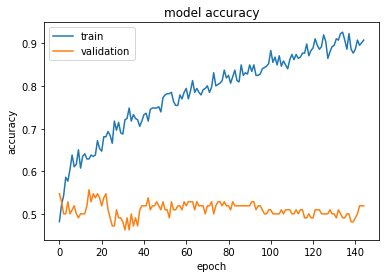

In [1070]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model = model.load_weights(r"C:\Users\cnaka\Class Notes\Capstone\mdl_wts.hdf5")

In [458]:
df=pd.DataFrame()
df["Forecast"]=(np.sqrt(norm.var_[0])*model.predict(X_test).T+norm.mean_[0]).flatten()
df["Actual"]=(np.sqrt(norm.var_[0])*Y_test.T+norm.mean_[0]).flatten()
df

,Forecast,Actual
0,416.466217,416.466204
1,416.466217,416.466204
2,411.114716,407.521970
3,409.609436,416.466204
4,410.318665,416.466204
...,...,...
538,416.459686,407.521970
539,416.465942,416.466204
540,416.466217,407.521970
541,416.466217,407.521970


In [229]:
df["Predicted Move"]=np.zeros(len(df))
df["Correct Sign"]=np.zeros(len(df))
for i in range(1,len(df["Forecast"])):
    df.iloc[i,2]=(np.sign(df["Forecast"][i]-df["Actual"][i-1])==1)
    if np.sign(df["Forecast"][i]-df["Actual"][i-1])==np.sign(df["Actual"][i]-df["Actual"][i-1]):
        df.iloc[i,3]=1
print("DPA={}".format(round(sum(df["Correct Sign"])/len(df["Correct Sign"]),2)))

DPA=0.48


In [457]:
A=np.argmax(model.predict(X_test),axis=1).reshape((543,1))==Y_test
sum([1 if i == True else 0 for i in A])/len(Y_test)

0.49171270718232046

In [455]:
test=norm.transform(data)
test[:,6]=data["direction"].values
X_test,Y_test=create_datasets(test,3,1,l=6)

## Spread

In [854]:
data =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Corn_CBOT_data.csv')
data["close"]=data["close"]/100
data = data[data["symbol"]=="ZCH20"]
data["tradingDay"]=pd.to_datetime(data["tradingDay"],format="%Y-%m-%d")
data=data.set_index("tradingDay")

In [855]:
cornspot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_CORN_cash_price.csv')
cornspot["tradingDay"]=pd.to_datetime(cornspot["tradingDay"],format="%Y-%m-%d")
cornspot=pd.DataFrame(cornspot.set_index("tradingDay")["close"]/100)
cornspot=cornspot.rename(columns={"close":"corn_spot"})
cornspot.head()

,corn_spot
tradingDay,
2000-01-03,2.0075
2000-01-04,2.0300
2000-01-05,2.0300
2000-01-06,2.0275
2000-01-07,2.0600


In [856]:
ethanolspot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_ethanol_cash_price.csv')
ethanolspot["tradingDay"]=pd.to_datetime(ethanolspot["tradingDay"],format="%Y-%m-%d")
ethanolspot=pd.DataFrame(ethanolspot.set_index("tradingDay")["close"])
ethanolspot=ethanolspot.rename(columns={"close":"ethanol_spot"})
ethanolspot.head()

,ethanol_spot
tradingDay,
2000-01-03,1.286
2000-01-04,1.285
2000-01-05,1.286
2000-01-06,1.280
2000-01-07,1.280


In [857]:
soydata =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Soybeans_CBOT_data.csv')
soydata = soydata[soydata["symbol"]=="ZSH20"]
soydata["tradingDay"]=pd.to_datetime(soydata["tradingDay"],format="%Y-%m-%d")
soydata=pd.DataFrame(soydata.set_index("tradingDay")["close"]).rename(columns={"close":"soybean_close"})

In [858]:
data=data.merge(soydata,left_index=True,right_index=True)
data["spread"]=data["close"]/data["soybean_close"]
data=data.drop(["soybean_close","open","high","low"],axis=1)

In [859]:
data["expiration_date"]=[pd.to_datetime("1900-12-31",format = "%Y-%m-%d")]*len(data)
for i in range(len(data)):
    quarter='01-31'
    if (data["symbol"][i][2]=='H'):
        quarter='03-31'
    elif (data["symbol"][i][2]=='K'):
        quarter='05-31'
    elif (data["symbol"][i][2]=='N'):
        quarter='07-31'
    elif (data["symbol"][i][2]=='U'):
        quarter='09-30'
    elif (data["symbol"][i][2]=='Z'):
        quarter='12-31'
    year = '20'+data["symbol"][i][3:]
    data.iloc[i,6]=pd.to_datetime(year+'-'+quarter,format = "%Y-%m-%d")

In [860]:
data["direction"] = np.zeros(len(data))
for i in range(1,len(data)):
    if data.iloc[i-1,5]>data.iloc[i,5]:
        data.iloc[i,7]=0
    else:
        data.iloc[i,7]=1


data["MA10"] = data["close"].shift(1).rolling(window=10).mean().fillna(0)
data["MA50"] = data["close"].shift(1).rolling(window=50).mean().fillna(0)
data["MA200"] = data["close"].shift(1).rolling(window=200).mean().fillna(0)
data["MACD"] = (data.close.ewm(span=12).mean().fillna(0)-data.close.ewm(span=26).mean().fillna(0))
data["MACD_Signal"]=data.MACD.ewm(span=9).mean().fillna(0)
data["MACD_Indicator"]=data["MACD"]-data["MACD_Signal"].fillna(0)
data["Bollinger_High"] = (data["close"].rolling(window=20).mean()+2*data["close"].rolling(window=20).std()).fillna(0)
data["Bollinger_Low"] = (data["close"].rolling(window=20).mean()-2*data["close"].rolling(window=20).std()).fillna(0)

spot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_CORN_cash_price.csv')
spot["tradingDay"]=pd.to_datetime(spot["tradingDay"],format="%Y-%m-%d")
spot=spot.set_index("tradingDay")
data=data.merge(spot["close"],on="tradingDay")
data=data.rename(columns={"close_y":"spot_price","close_x":"close"})

In [861]:
data["days_until_maturity"]=(data.index.values-data["expiration_date"]).dt.days

In [862]:
WASDE= pd.read_csv(r"C:\Users\cnaka\Class Notes\Capstone\Corn WASDE Rolling Forecast data.csv")
WASDE["date"]=pd.to_datetime(WASDE.date,format="%Y-%m-%d")
WASDE= pd.pivot_table(WASDE,values='value',index='date',columns='series_id')
WASDE["Supply"]=WASDE[141539]
WASDE["Demand"]=WASDE[141531]+WASDE[141533]
WASDE=WASDE[["Supply","Demand"]]

In [863]:
data=data.merge(WASDE,left_index=True,right_index=True,how="left").merge(ethanolspot,left_index=True,right_index=True,how="left").merge(cornspot,left_index=True,right_index=True,how="left")

In [864]:
oil=pdr.get_data_yahoo("USO", start="2000-01-01", end="2021-02-23")
usd=pdr.get_data_yahoo("DX-Y.NYB", start="2000-01-01", end="2021-02-23")
oil=oil["Close"]
usd=usd["Close"]
data=data.merge(oil,left_index=True,right_on="Date",how="left").rename(columns={"Close":"Oil"}).merge(usd,left_index=True,right_on="Date",how="left").rename(columns={"Close":"USD"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [865]:
ethanol=pd.read_csv('ethanol_demand.csv')
ethanol['Week_End']=pd.to_datetime(ethanol['Week_End'],format="%m/%d/%Y")
ethanol['BBL_Day']=pd.to_numeric(ethanol['BBL_Day'])
data=data.merge(ethanol,left_on="Date",right_on="Week_End",how="left")

In [866]:
data[["Supply","Demand",'Oil','USD','Week_End','BBL_Day','Gal_Day']]=data[["Supply","Demand",'Oil','USD','Week_End','BBL_Day','Gal_Day']].fillna(method='ffill')

In [867]:
data=data.dropna().drop(["Week_End",'timestamp','symbol','expiration_date','Gal_Day'],axis=1).set_index("Date")

In [868]:
trainraw=data.loc[data.index[0]:data.index[round(len(data)*.6)]]
validateraw=data.loc[data.index[round(len(data)*.6)+1]:data.index[round(len(data)*.8)]]
testraw=data.loc[data.index[round(len(data)*.8)+1]:data.index[-1]]

In [869]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
train=norm.fit_transform(trainraw)
train[:,4]=trainraw["direction"].values
validate=norm.transform(validateraw)
validate[:,4]=validateraw["direction"].values
test=norm.transform(testraw)
test[:,4]=testraw["direction"].values

In [874]:
X_train,Y_train=create_datasets(train,3,1,l=4)
X_validate,Y_validate=create_datasets(validate,3,1,l=4)
X_test,Y_test=create_datasets(test,3,1,l=4)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(326, 3, 13) (326, 1)
(106, 3, 13) (106, 1)
(105, 3, 13) (105, 1)


In [875]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
mcp_save = tf.keras.callbacks.ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]],activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.LSTM(80,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer = "adam",metrics=[tf.keras.metrics.BinaryAccuracy()])

In [876]:
model.fit(x=X_train,y=Y_train,epochs=39,validation_data=(X_validate,Y_validate),callbacks=[earlystop,mcp_save],verbose=2
         )

Epoch 1/39
11/11 - 1s - loss: 0.6983 - binary_accuracy: 0.5491 - val_loss: 0.8361 - val_binary_accuracy: 0.4906
Epoch 2/39
11/11 - 1s - loss: 0.6868 - binary_accuracy: 0.5613 - val_loss: 0.7753 - val_binary_accuracy: 0.4906
Epoch 3/39
11/11 - 1s - loss: 0.6794 - binary_accuracy: 0.5552 - val_loss: 0.7506 - val_binary_accuracy: 0.4623
Epoch 4/39
11/11 - 1s - loss: 0.6731 - binary_accuracy: 0.5890 - val_loss: 0.7534 - val_binary_accuracy: 0.4340
Epoch 5/39
11/11 - 1s - loss: 0.6727 - binary_accuracy: 0.5736 - val_loss: 0.7667 - val_binary_accuracy: 0.4528
Epoch 6/39
11/11 - 1s - loss: 0.6733 - binary_accuracy: 0.5736 - val_loss: 0.7609 - val_binary_accuracy: 0.4245
Epoch 7/39
11/11 - 1s - loss: 0.6695 - binary_accuracy: 0.5982 - val_loss: 0.7774 - val_binary_accuracy: 0.4245
Epoch 8/39
11/11 - 1s - loss: 0.6707 - binary_accuracy: 0.5798 - val_loss: 0.7830 - val_binary_accuracy: 0.3868
Epoch 9/39
11/11 - 1s - loss: 0.6686 - binary_accuracy: 0.6043 - val_loss: 0.7895 - val_binary_accuracy:

In [740]:
model.load_weights('mdl_wts.hdf5')

In [873]:
model.evaluate(X_test,Y_test)

4/4 [==============================] - 0s 43ms/step - loss: 1.1015 - binary_accuracy: 0.4860


[1.1014530658721924, 0.4859813153743744]

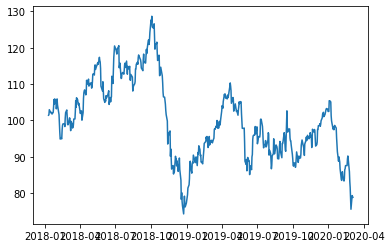

In [771]:
plt.plot(data["Oil"])

In [682]:
train[250]

array([-0.38730969, -0.19242974,  0.07635706, -0.3268837 ,  0.        ,
        0.92710699,  0.68236444,  0.23494716,  0.9172781 ,  0.99993073,
        0.85614292,  0.91369215,  0.61345316,  0.27072022,  0.92876921,
        0.93617139,  0.93617139,  0.86153663,  0.        ,  0.21749823,
        0.        ,  1.12563209,  1.63725469, -2.70045258])

In [772]:
data.head()

,close,volume,openInterest,spread,direction,days_until_maturity,Supply,Demand,ethanol_spot,corn_spot,Oil,USD,BBL_Day
Date,,,,,,,,,,,,,
2018-01-10,4.0875,0,4,2.6895,0.0,-811,16947.48,14470.1,1.280,3.4100,101.440002,92.330002,795.0
2018-01-11,4.0875,4,8,2.6835,0.0,-810,16947.48,14470.1,1.280,3.4175,101.599998,91.849998,795.0
2018-01-12,4.0650,4,8,2.6610,0.0,-809,16947.48,14470.1,1.265,3.4075,102.959999,90.970001,856.0
2018-01-16,4.0850,0,8,2.6830,1.0,-805,16947.48,14470.1,1.265,3.4375,102.080002,90.389999,856.0
2018-01-17,4.1300,12,13,2.7330,1.0,-804,16947.48,14470.1,1.265,3.5050,102.239998,90.540001,856.0


## Spot Spread

In [2]:
cornspot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_CORN_cash_price.csv')
cornspot["tradingDay"]=pd.to_datetime(cornspot["tradingDay"],format="%Y-%m-%d")
cornspot=pd.DataFrame(cornspot.set_index("tradingDay")["close"]/100)
cornspot=cornspot.rename(columns={"close":"corn_spot"})
ethanolspot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_ethanol_cash_price.csv')
ethanolspot["tradingDay"]=pd.to_datetime(ethanolspot["tradingDay"],format="%Y-%m-%d")
ethanolspot=pd.DataFrame(ethanolspot.set_index("tradingDay")["close"])
ethanolspot=ethanolspot.rename(columns={"close":"ethanol_spot"})
soyspot = pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\CBOT_soybeans_cash_price.csv')
soyspot["tradingDay"]=pd.to_datetime(soyspot["tradingDay"],format="%Y-%m-%d")
soyspot=pd.DataFrame(soyspot.set_index("tradingDay")["close"]/100)
soyspot=soyspot.rename(columns={"close":"soybean_spot"})
data=cornspot.merge(ethanolspot,left_index=True,right_index=True).merge(soyspot,left_index=True,right_index=True)
data["spread_ratio"]=data["soybean_spot"]/data["corn_spot"]
data["direction"] = np.zeros(len(data))
for i in range(1,len(data)):
    if data.iloc[i-1,3]>data.iloc[i,3]:
        data.iloc[i,4]=0
    else:
        data.iloc[i,4]=1
data.head()

,corn_spot,ethanol_spot,soybean_spot,spread_ratio,direction
tradingDay,,,,,
2000-01-03,2.0075,1.286,4.445,2.214197,0.0
2000-01-04,2.0300,1.285,4.510,2.221675,1.0
2000-01-05,2.0300,1.286,4.560,2.246305,1.0
2000-01-06,2.0275,1.280,4.545,2.241677,0.0
2000-01-07,2.0600,1.280,4.590,2.228155,0.0


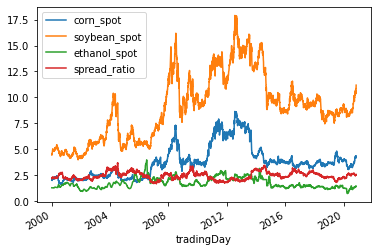

In [1078]:
data[["corn_spot","soybean_spot","ethanol_spot","spread_ratio"]].plot(kind="line")

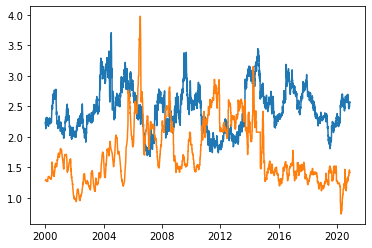

In [812]:
plt.plot(data[["spread","ethanol_spot"]])

In [3]:
trainraw=data.loc[data.index[0]:data.index[round(len(data)*.6)]]
validateraw=data.loc[data.index[round(len(data)*.6)+1]:data.index[round(len(data)*.8)]]
testraw=data.loc[data.index[round(len(data)*.8)+1]:data.index[-1]]

In [4]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()
train=norm.fit_transform(trainraw)
train[:,4]=trainraw["direction"].values
validate=norm.transform(validateraw)
validate[:,4]=validateraw["direction"].values
test=norm.transform(testraw)
test[:,4]=testraw["direction"].values

In [25]:
X_train,Y_train=create_datasets(train,10,1,l=4)
X_validate,Y_validate=create_datasets(validate,10,1,l=4)
X_test,Y_test=create_datasets(test,10,1,l=4)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(3136, 10, 5) (3136, 1)
(1039, 10, 5) (1039, 1)
(1037, 10, 5) (1037, 1)


In [33]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
mcp_save = tf.keras.callbacks.ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')
model=keras.models.Sequential([
    keras.layers.Conv1D(12,5,input_shape = [X_train.shape[1],X_train.shape[2]],),
    keras.layers.LSTM(200,return_sequences=True,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.8),
    keras.layers.LSTM(200,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer = "adam",metrics=[tf.keras.metrics.BinaryAccuracy()])

In [30]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)
mcp_save = tf.keras.callbacks.ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_binary_accuracy', mode='max')
model=keras.models.Sequential([
    keras.layers.LSTM(200,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]],activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dropout(.8),
    keras.layers.LSTM(200,activation='selu',kernel_initializer='lecun_normal'),
    keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss="binary_crossentropy",optimizer = "adam",metrics=[tf.keras.metrics.BinaryAccuracy()])

In [34]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 6, 12)             312       
_________________________________________________________________
lstm_15 (LSTM)               (None, 6, 200)            170400    
_________________________________________________________________
dropout_6 (Dropout)          (None, 6, 200)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 491,713
Trainable params: 491,713
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit(x=X_train,y=Y_train,epochs=1000,validation_data=(X_validate,Y_validate),callbacks=[earlystop,mcp_save],verbose=2
         )

Epoch 1/1000
98/98 - 5s - loss: 0.7707 - binary_accuracy: 0.5029 - val_loss: 0.7092 - val_binary_accuracy: 0.5217
Epoch 2/1000
98/98 - 5s - loss: 0.7174 - binary_accuracy: 0.4987 - val_loss: 0.7043 - val_binary_accuracy: 0.5140
Epoch 3/1000
98/98 - 5s - loss: 0.7074 - binary_accuracy: 0.5185 - val_loss: 0.6991 - val_binary_accuracy: 0.5072
Epoch 4/1000
98/98 - 5s - loss: 0.7047 - binary_accuracy: 0.4968 - val_loss: 0.7048 - val_binary_accuracy: 0.4957
Epoch 5/1000
98/98 - 5s - loss: 0.6982 - binary_accuracy: 0.5102 - val_loss: 0.7169 - val_binary_accuracy: 0.5140
Epoch 6/1000
98/98 - 5s - loss: 0.6985 - binary_accuracy: 0.5080 - val_loss: 0.7030 - val_binary_accuracy: 0.4937
Epoch 7/1000
98/98 - 5s - loss: 0.6983 - binary_accuracy: 0.5073 - val_loss: 0.7136 - val_binary_accuracy: 0.5014
Epoch 8/1000
98/98 - 5s - loss: 0.6987 - binary_accuracy: 0.5032 - val_loss: 0.7024 - val_binary_accuracy: 0.4976
Epoch 9/1000
98/98 - 5s - loss: 0.6933 - binary_accuracy: 0.5147 - val_loss: 0.6999 - va

Epoch 73/1000
98/98 - 6s - loss: 0.6233 - binary_accuracy: 0.6307 - val_loss: 0.9967 - val_binary_accuracy: 0.4889
Epoch 74/1000
98/98 - 6s - loss: 0.6142 - binary_accuracy: 0.6384 - val_loss: 1.0978 - val_binary_accuracy: 0.5043
Epoch 75/1000
98/98 - 6s - loss: 0.6206 - binary_accuracy: 0.6307 - val_loss: 1.2392 - val_binary_accuracy: 0.4976
Epoch 76/1000
98/98 - 6s - loss: 0.6109 - binary_accuracy: 0.6476 - val_loss: 0.9794 - val_binary_accuracy: 0.4880
Epoch 77/1000
98/98 - 6s - loss: 0.6041 - binary_accuracy: 0.6473 - val_loss: 1.0410 - val_binary_accuracy: 0.5063
Epoch 78/1000
98/98 - 6s - loss: 0.5899 - binary_accuracy: 0.6623 - val_loss: 1.0748 - val_binary_accuracy: 0.4706
Epoch 79/1000
98/98 - 6s - loss: 0.5945 - binary_accuracy: 0.6531 - val_loss: 1.1816 - val_binary_accuracy: 0.4735
Epoch 80/1000
98/98 - 6s - loss: 0.5764 - binary_accuracy: 0.6719 - val_loss: 1.1816 - val_binary_accuracy: 0.4899
Epoch 81/1000
98/98 - 6s - loss: 0.5761 - binary_accuracy: 0.6751 - val_loss: 1.

Epoch 144/1000
98/98 - 6s - loss: 0.1151 - binary_accuracy: 0.9563 - val_loss: 3.0654 - val_binary_accuracy: 0.5014
Epoch 145/1000
98/98 - 6s - loss: 0.1245 - binary_accuracy: 0.9554 - val_loss: 2.7050 - val_binary_accuracy: 0.5168
Epoch 146/1000
98/98 - 6s - loss: 0.1283 - binary_accuracy: 0.9550 - val_loss: 2.7043 - val_binary_accuracy: 0.5091
Epoch 147/1000
98/98 - 6s - loss: 0.1206 - binary_accuracy: 0.9563 - val_loss: 2.6271 - val_binary_accuracy: 0.5072
Epoch 148/1000
98/98 - 6s - loss: 0.1117 - binary_accuracy: 0.9563 - val_loss: 2.8674 - val_binary_accuracy: 0.4966
Epoch 149/1000
98/98 - 6s - loss: 0.0973 - binary_accuracy: 0.9646 - val_loss: 2.9316 - val_binary_accuracy: 0.4957
Epoch 150/1000
98/98 - 6s - loss: 0.0893 - binary_accuracy: 0.9691 - val_loss: 3.0313 - val_binary_accuracy: 0.4928
Epoch 151/1000
98/98 - 6s - loss: 0.0829 - binary_accuracy: 0.9691 - val_loss: 3.0650 - val_binary_accuracy: 0.4976
Epoch 152/1000
98/98 - 6s - loss: 0.0661 - binary_accuracy: 0.9751 - val

KeyboardInterrupt: 

In [10]:
model.load_weights('mdl_wts.hdf5')

In [11]:
model.evaluate(X_test,Y_test)

33/33 [==============================] - 1s 15ms/step - loss: 0.7839 - binary_accuracy: 0.5192


[0.7839099168777466, 0.5191571116447449]

In [12]:
model.predict(X_test)

array([[0.63495386],
       [0.6746571 ],
       [0.56912833],
       ...,
       [0.8512891 ],
       [0.88595057],
       [0.954787  ]], dtype=float32)

In [16]:
soydata =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Soybeans_CBOT_data.csv')
soydata["close"]=soydata["close"]/100
soydata = soydata[soydata["symbol"]=="ZSH19"]
soydata=soydata.drop(["open","high","low","volume","openInterest","symbol","timestamp"],axis=1)
soydata["tradingDay"]=pd.to_datetime(soydata["tradingDay"],format="%Y-%m-%d")
soydata=pd.DataFrame(soydata.set_index("tradingDay")["close"]).rename(columns={"close":"soybean_close"})
data =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Corn_CBOT_data.csv')
data["close"]=data["close"]/100
data = data[data["symbol"]=="ZCH20"]
data["tradingDay"]=pd.to_datetime(data["tradingDay"],format="%Y-%m-%d")
data=data.set_index("tradingDay")
data=data.drop(["open","high","low","volume","openInterest","symbol","timestamp"],axis=1)
ethanoldata =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Ethanol_CBOT_data.csv')
ethanoldata = ethanoldata[ethanoldata["symbol"]=="ZKH19"]
ethanoldata=ethanoldata.drop(["open","high","low","volume","openInterest","symbol","timestamp"],axis=1)
ethanoldata["tradingDay"]=pd.to_datetime(ethanoldata["tradingDay"],format="%Y-%m-%d")
ethanoldata=pd.DataFrame(ethanoldata.set_index("tradingDay")["close"]).rename(columns={"close":"ethanol_close"})

data=data.merge(ethanoldata,left_index=True,right_index=True).merge(soydata,left_index=True,right_index=True)
data["spread"]=data["soybean_close"]/data["close"]
data["direction"] = np.zeros(len(data))
for i in range(1,len(data)):
    if data.iloc[i-1,3]>data.iloc[i,3]:
        data.iloc[i,4]=0
    else:
        data.iloc[i,4]=1
data.head()

,close,ethanol_close,soybean_close,spread,direction
tradingDay,,,,,
2017-12-14,4.0475,1.380,9.9750,2.464484,0.0
2017-12-15,4.0425,1.374,9.9750,2.467532,1.0
2017-12-18,4.0500,1.382,9.9300,2.451852,0.0
2017-12-19,4.0700,1.381,9.8825,2.428133,0.0
2017-12-20,4.0675,1.381,9.8750,2.427781,0.0


In [17]:
datanorm=norm.transform(data)
datanorm[:,4]=data["direction"].values
X_data,Y_data=create_datasets(datanorm,3,1,l=4)
print(X_data.shape,Y_data.shape)

(303, 3, 5) (303, 1)


In [18]:
model.evaluate(X_data,Y_data)


 5/10 [==============>...............] - ETA: 0s - loss: 0.9075 - binary_accuracy: 0.4688

C:\Users\cnaka\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


10/10 [==============================] - 0s 15ms/step - loss: 0.8556 - binary_accuracy: 0.4686


[0.8555895090103149, 0.4686468541622162]

In [1035]:
X_data

array([[[ 0.37126067, -0.84922185,  0.57567802,  0.08865929,
          0.        ],
        [ 0.36816991, -0.86109395,  0.57646567,  0.09854072,
          1.        ],
        [ 0.37280605, -0.84526448,  0.56386319,  0.05933176,
          0.        ]],

       [[ 0.36816991, -0.86109395,  0.57646567,  0.09854072,
          1.        ],
        [ 0.37280605, -0.84526448,  0.56386319,  0.05933176,
          0.        ],
        [ 0.38516909, -0.84724316,  0.55204836,  0.00180087,
          0.        ]],

       [[ 0.37280605, -0.84526448,  0.56386319,  0.05933176,
          0.        ],
        [ 0.38516909, -0.84724316,  0.55204836,  0.00180087,
          0.        ],
        [ 0.38362371, -0.84724316,  0.55047305,  0.00246973,
          1.        ]],

       ...,

       [[ 0.15954357, -1.05104755,  0.25116403, -0.05651413,
          1.        ],
        [ 0.12245444, -1.09853595,  0.26770479,  0.08942946,
          1.        ],
        [ 0.13481748, -1.09853595,  0.25904058,  0.032813

##  All Contracts

In [939]:
data =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Corn_CBOT_data.csv')
data["close"]=data["close"]/100
data["tradingDay"]=pd.to_datetime(data["tradingDay"],format="%Y-%m-%d")

In [940]:
data["expiration_date"]=[pd.to_datetime("1900-12-31",format = "%Y-%m-%d")]*len(data)
for i in range(len(data)):
    quarter='01-31'
    if (data["symbol"][i][2]=='H'):
        quarter='03-31'
    elif (data["symbol"][i][2]=='K'):
        quarter='05-31'
    elif (data["symbol"][i][2]=='N'):
        quarter='07-31'
    elif (data["symbol"][i][2]=='U'):
        quarter='09-30'
    elif (data["symbol"][i][2]=='Z'):
        quarter='12-31'
    year = '20'+data["symbol"][i][3:]
    data.iloc[i,9]=pd.to_datetime(year+'-'+quarter,format = "%Y-%m-%d")

In [941]:
soydata =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Soybeans_CBOT_data.csv')
soydata["close"]=soydata["close"]/100
soydata["tradingDay"]=pd.to_datetime(soydata["tradingDay"],format="%Y-%m-%d")

In [942]:
soydata["expiration_date"]=[pd.to_datetime("1900-12-31",format = "%Y-%m-%d")]*len(soydata)
for i in range(len(soydata)):
    quarter='01-31'
    if (soydata["symbol"][i][2]=='H'):
        quarter='03-31'
    elif (soydata["symbol"][i][2]=='K'):
        quarter='05-31'
    elif (soydata["symbol"][i][2]=='N'):
        quarter='07-31'
    elif (soydata["symbol"][i][2]=='U'):
        quarter='09-30'
    elif (soydata["symbol"][i][2]=='Z'):
        quarter='12-31'
    year = '20'+soydata["symbol"][i][3:]
    soydata.iloc[i,9]=pd.to_datetime(year+'-'+quarter,format = "%Y-%m-%d")

In [943]:
soydata=soydata.drop(["open","high","low","volume","openInterest","timestamp","symbol"],axis=1).rename(columns={"close":"soy_close"})

In [944]:
data=data.merge(soydata,left_on=["tradingDay","expiration_date"],right_on=["tradingDay","expiration_date"]).drop(["timestamp","open","high","low"],axis=1)

In [945]:
ethanoldata =  pd.read_csv(r'C:\Users\cnaka\Class Notes\Capstone\Ethanol_CBOT_data.csv')
ethanoldata["close"]=ethanoldata["close"]
ethanoldata["tradingDay"]=pd.to_datetime(ethanoldata["tradingDay"],format="%Y-%m-%d")
ethanoldata["expiration_date"]=[pd.to_datetime("1900-12-31",format = "%Y-%m-%d")]*len(ethanoldata)
for i in range(len(ethanoldata)):
    quarter='01-31'
    if (ethanoldata["symbol"][i][2]=='H'):
        quarter='03-31'
    elif (ethanoldata["symbol"][i][2]=='K'):
        quarter='05-31'
    elif (ethanoldata["symbol"][i][2]=='N'):
        quarter='07-31'
    elif (ethanoldata["symbol"][i][2]=='U'):
        quarter='09-30'
    elif (ethanoldata["symbol"][i][2]=='Z'):
        quarter='12-31'
    year = '20'+ethanoldata["symbol"][i][3:]
    ethanoldata.iloc[i,9]=pd.to_datetime(year+'-'+quarter,format = "%Y-%m-%d")
ethanoldata=ethanoldata.drop(["open","high","low","volume","openInterest","timestamp","symbol"],axis=1).rename(columns={"close":"ethanol_close"})
data=data.merge(ethanoldata,left_on=["tradingDay","expiration_date"],right_on=["tradingDay","expiration_date"])

In [950]:
data["ratio"]=data["soy_close"]/data["close"]
data["direction"] = np.zeros(len(data))
for i in range(1,len(data)):
    if (data.iloc[i-1,8]<=data.iloc[i,8] and data.iloc[i-1,0]==data.iloc[i,0]):
        data.iloc[i,9]=1

In [951]:
data.head()

,symbol,tradingDay,close,volume,openInterest,expiration_date,soy_close,ethanol_close,ratio,direction
0,ZCH06,2005-08-15,2.3300,11450,76778,2006-03-31,6.2725,1.63,2.692060,0.0
1,ZCH06,2005-08-16,2.3200,8088,77348,2006-03-31,6.3250,1.68,2.726293,1.0
2,ZCH06,2005-08-17,2.3625,7867,77809,2006-03-31,6.3425,1.69,2.684656,0.0
3,ZCH06,2005-08-18,2.3450,5676,77012,2006-03-31,6.3300,1.71,2.699360,1.0
4,ZCH06,2005-08-19,2.3300,6500,77425,2006-03-31,6.2050,1.70,2.663090,0.0


In [1060]:
history.history.keys()

NameError: name 'history' is not defined